# Estimacion de produccion de Aceite

El modelo consiste en generar una estimacion de la produccion del siguinte mes con informacion de 1 año de produccion

Variables:

+ Produccion de Aceite y de Gas
+ 12 rezagos La produccion al tiempo $t_i$
+ estadisticos de tendencias:
    + Factores de declinacion
    + diferencia de produccion
    + ratio de produccion
    + conteo de subidas o bajadas en produccion
    + medias moviles
    + velocidad y aceleracion de produccion

+ Estadistica de produccion de aceite y gas:
    + desviacion estandar
    + mediana
    + minimo
    + maximo
    + quantiles 10,25,75,90
    + rango
+ tipo de equipo de perforacion
+ dummie de mes
+ clustering


Se decidio generar los conjuntos de entrenamiento, prueba y validacion con un muestreo aleatorio, es decir, puede tomar cualquier fecha. En lugar de partir nuestros datos en temporadas. Esto con el fin de aprender tendencias de cualquier momento y actuales (*).

El notebook comienza con algunos descriptivos para saber el contexto de los datos. Posteriormente comenzamos con la preparacion de los datos y la generacion de variables. Una ves que generamos todas las variables se hace su analisis para quitar datos atipicos (outliers). Se genera un clustering para agrupar pozos y ayudarle al modelo a predecir mejor la produccion y se genera la variable correspondiente. Se analizan las variables con respecto a la variable dependiente analizando tendencias y correlaciones. Se entreno el modelo con 6K registros y se utilizo el algoritmo de Lightgbm que consiste en un GBM regularizado y con crecimiento por hojas en lugar de niveles de profundidad.

Se obtuvo un error de:

+ MEA: 11.15
+ RMSE: 34.81
+ $R^2$: 0.914
+ Residuo porcental promedio: -1.6% el signo menos significa que sobreestima el valor.

Las variables mas importantes son:
+ Produccion de barriles mes t-1
+ Diferencia de produccion de t-2 y t-1
+ desviacion estandar
+ ratio de la produccion de barriles al tiempo t-2 y t-1

Se genera un forecasting actualizando los valores reales de produccion por la estimacion y se predice mes con mes durante 10 años. Se observa que el modelo aprende la estacionalidad de produccion y predice adecuadamente durante 5 años. obteniendo un residuo promedio de 11.51 barriles mensuales.

(*) Puede que presenta future leakage, sin embargo no se observa que una variable lo tenga.

In [1]:
#triada de la death
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (12,8)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }

plt.style.use('ggplot')

# Modelos
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import metrics
# Interpretacion
import shap
from pdpbox import pdp, info_plots

#mis tools
import sys
sys.path.append('../serch_tools/')
import serch_tools as st

In [2]:
# aforos = pd.read_csv("datos/aforos.csv")
# analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
# columna_geologica = pd.read_csv('datos/columna_geologica.csv')
# eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
# intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
# parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [3]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [4]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [5]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [6]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [7]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


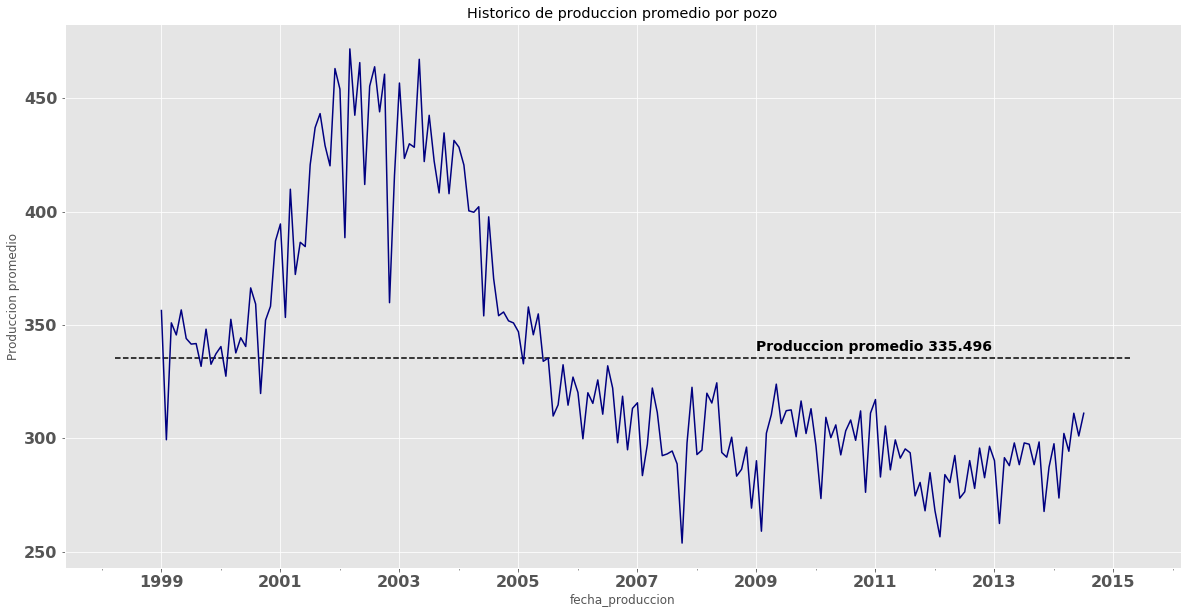

In [8]:
db_prod_mol.groupby('fecha_produccion').Qo_mes_b.mean().plot(figsize=(20,10), color='navy',
    title='Historico de produccion promedio por pozo')
mi,ma = plt.xlim()
plt.hlines(db_prod_mol.groupby('fecha_produccion').Qo_mes_b.mean().mean(),mi,ma,linestyles='--')
plt.text('2009-01-01',db_prod_mol.groupby('fecha_produccion').Qo_mes_b.mean().mean()+3,
         "Produccion promedio %1.3f" %db_prod_mol.groupby('fecha_produccion').Qo_mes_b.mean().mean(),fontsize=14)
plt.ylabel('Produccion promedio');

Se observa una subida y bajada de produccion durante los años 2000 al 2005, donde claramente no se observa una estacionalidad.

__Se quitaran esos datos con el fin de tener una serie de tiempo estacional.__

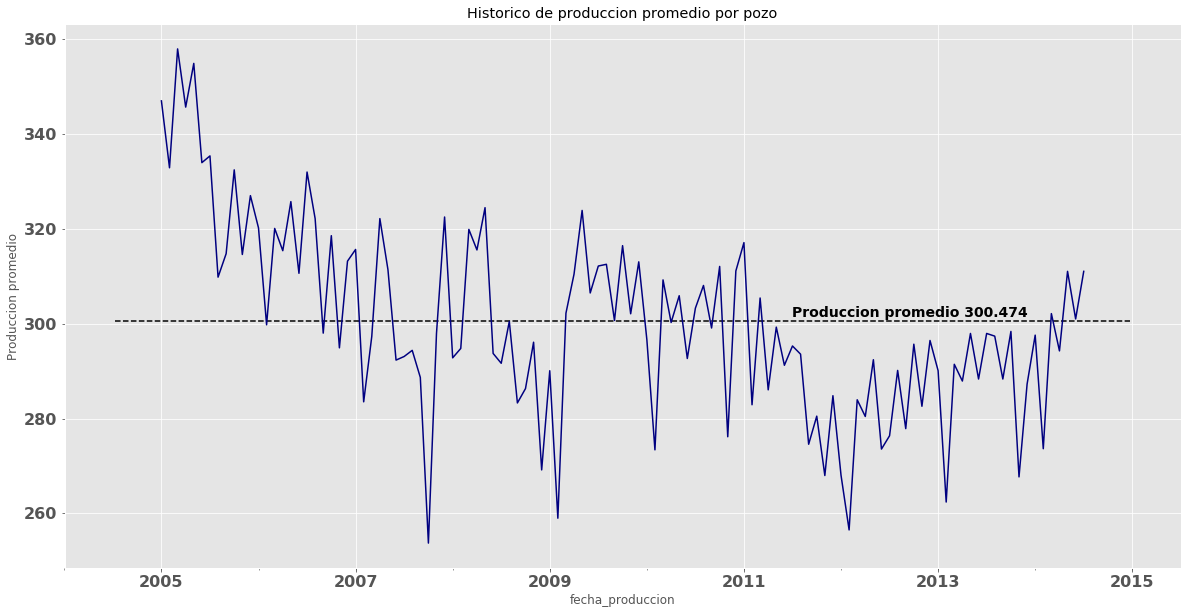

In [9]:
db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().plot(figsize=(20,10), color='navy',
    title='Historico de produccion promedio por pozo')
mi,ma = plt.xlim()
plt.hlines(db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().mean(),mi,ma,linestyles='--')
plt.text('2011-07-01',db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().mean()+1,
         "Produccion promedio %1.3f" %db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qo_mes_b.mean().mean(),fontsize=14)
plt.ylabel('Produccion promedio');

In [243]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion', 'fecha_produccion', 'f_prod'],
      dtype='object')

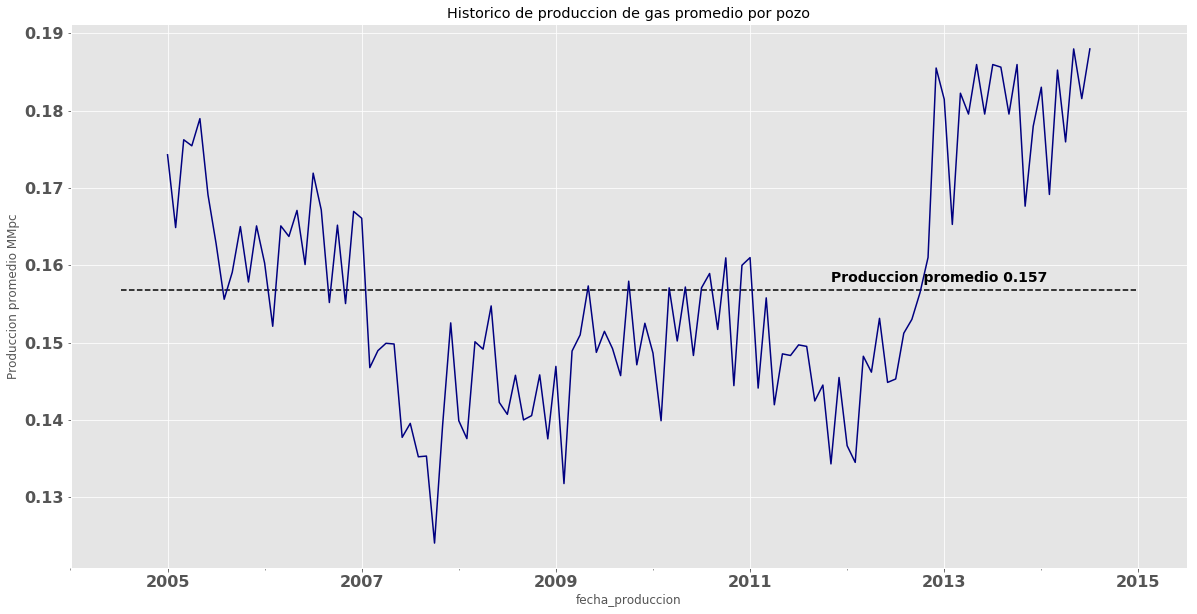

In [254]:
db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qg_mes_MMpc.mean().plot(figsize=(20,10), color='navy',
    title='Historico de produccion de gas promedio por pozo')
mi,ma = plt.xlim()
plt.hlines(db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qg_mes_MMpc.mean().mean(),mi,ma,linestyles='--')
plt.text('2011-11-01',db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qg_mes_MMpc.mean().mean()+0.001,
         "Produccion promedio %1.3f" %db_prod_mol[
    db_prod_mol.fecha_produccion>='2005-01-01'].groupby('fecha_produccion').Qg_mes_MMpc.mean().mean(),fontsize=14)
plt.ylabel('Produccion promedio MMpc');

Para el modelo de gas no vemos una estacionalidad clara, a diferencia que en el de petroleo

In [10]:
# SOLO SE TRABAJA CON 10 ANIOS Y SE QUITA UNA FECHA ATIPICA
db_prod_mol = db_prod_mol[(db_prod_mol.fecha_produccion > '2004-12-01')
#                           & (db_prod_mol.fecha_produccion != '2013-08-01')
#                           & (db_prod_mol.fecha_produccion != '2013-07-01') & (db_prod_mol.fecha_produccion != '2013-06-01')
                         ]

In [11]:
db_prod_mol.fecha_produccion.describe()

count                   11571
unique                    115
top       2005-05-01 00:00:00
freq                      125
first     2005-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

Se trabajara con 9 años de historico.

# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 12 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1) + \beta_2 P(t-2) + \beta_3 P(t-3) + \beta_4 P(t-4) + \beta_5 P(t-5) + \beta_6 P(t-6)+ + \beta_7 P(t-7) +  + \beta_8 P(t-8) + \beta_9 P(t-9) + \beta_{10} P(t-10) + \beta_{11} P(t-11) + \beta_{12} P(t-12) +\sum \beta_iX_i + \epsilon$

__Se hace una transformacion para hacer la serie estacionaria de manera que haremos el predict como:__

$\hat{y(t)} = \frac{y(t)}{y(t-1)} = f(x)$

Los rezagos ahora se calculan como $\frac{t-1}{t-2}$ y $\frac{t-2}{t-3}$

In [99]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

### check de y estacionaria

In [100]:
db_prod_mol.groupby(['Pozo','fecha_produccion'])['Qo_mes_b'].first().head()

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          194.98
               2005-02-01          157.25
               2005-03-01          147.68
               2005-04-01          191.55
               2005-05-01          187.08
Name: Qo_mes_b, dtype: float64

In [101]:
t_real.head(5)

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          157.25
               2005-02-01          147.68
               2005-03-01          191.55
               2005-04-01          187.08
               2005-05-01          134.89
Name: Qo_mes_b, dtype: float64

In [102]:
t_1_real.head()

Pozo           fecha_produccion
MOLOACAN-1004  2005-01-01          194.98
               2005-02-01          157.25
               2005-03-01          147.68
               2005-04-01          191.55
               2005-05-01          187.08
Name: Qo_mes_b, dtype: float64

## Generacion de y_estacionaria

In [103]:
Tsota = (t_real/t_1_real).dropna()

In [104]:
# tabla (t - 12)
t = Tsota

# tabla (t - 11)
t_1 = Tsota.shift(-1)

# tabla (t -10)
t_2 = Tsota.shift(-2)

# tabla (t - 9)
t_3 = Tsota.shift(-3)

# tabla (t - 8)
t_4 =Tsota.shift(-4)

# tabla (t -7)
t_5 = Tsota.shift(-5)

# tabla (t - 6)
t_6 = Tsota.shift(-6)

# tabla (t - 5)
t_7 = Tsota.shift(-7)

#tabla (t - 4) 
t_8 = Tsota.shift(-8)

#tabla (t - 3) 
t_9 = Tsota.shift(-9)

#tabla (t - 2) 
t_10 = Tsota.shift(-10)

#tabla (t - 1) 
t_11 = Tsota.shift(-11)

#tabla (t)  variable a estimar
t_12 = Tsota.shift(-12)

In [105]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-12)

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-13)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [106]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_1_real,t_real],1).dropna()
df.columns = ['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t','y_real_oil_t_1','y_real_oil']

### check de y real y y real menos 1

In [107]:
190.96/148.13

1.289137919395126

In [108]:
160.17/148.13

1.0812799567947073

In [109]:
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.149537   
              2005-02-01                       1.052585   
              2005-03-01                       0.

In [110]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

In [111]:
#tabla (t)  fecha real
fecha_de_y = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-13)

In [112]:
df = pd.merge(df, pd.DataFrame(fecha_de_y), left_index=True, right_index=True)
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.149537   
              2005-02-01                       1.052585   
              2005-03-01                       0.

Listo ya se le pego el valor real y el anterior para poder regresar durante la prediccion

In [113]:
df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

# cambio en la produccion
df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [114]:
df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

# cambio en la produccion
df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1

In [115]:
df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                        'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                        'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [116]:
# desviacion estandar
df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                           'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi.., tambien sirve para tner una cota inferior de produccion
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 12 meses

In [117]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [118]:
df['produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)

Suma de produccion anual

In [119]:
df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

Tasas de declinacion anual $D=-\frac{ln(\frac{q_{12}}{q_{1}})}{12}$

Tasas de declinacion efectiva $D=-\frac{(q_{12}-q_{1})}{q_{12}}$

Referencia http://www.portaldelpetroleo.com/2012/07/bpd-curvas-de-declinacion-de-produccion.html

In [120]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 4*df.std_t_12_t_1 > df.Produccion_barriles_t,1,0)

In [121]:
df[df.dummi_pico_bajo==1].shape

(187, 91)

In [122]:
df = df[df.dummi_pico_bajo!=1]

Se aplica filtro de picos bajos

# variables del modelo de gas

In [123]:
# # tabla (t-1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first()

# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-1)

In [124]:
Tsota = (t/t_1).dropna()

In [125]:
# tabla (t - 12)
t = Tsota

# tabla (t - 11)
t_1 = Tsota.shift(-1)

# tabla (t -10)
t_2 = Tsota.shift(-2)

# tabla (t - 9)
t_3 = Tsota.shift(-3)

# tabla (t - 8)
t_4 =Tsota.shift(-4)

# tabla (t -7)
t_5 = Tsota.shift(-5)

# tabla (t - 6)
t_6 = Tsota.shift(-6)

# tabla (t - 5)
t_7 = Tsota.shift(-7)

#tabla (t - 4) 
t_8 = Tsota.shift(-8)

#tabla (t - 3) 
t_9 = Tsota.shift(-9)

#tabla (t - 2) 
t_10 = Tsota.shift(-10)

#tabla (t - 1) 
t_11 = Tsota.shift(-11)

#tabla (t)  variable a estimar
t_12 = Tsota.shift(-12)

In [126]:
# # tabla (t-1)
t_1_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-12)

# tabla (t)
t_real = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qg_mes_MMpc.first().shift(-13)

In [127]:
t_gas = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_1_real,t_real],1).dropna()
t_gas.columns = ['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1',
              'Produccion_gasMMpc_t','y_real_gas_t_1','y_real_gas']

In [128]:
df = pd.merge(df,t_gas, right_index=True, left_index=True).dropna()

In [129]:
df.shape

(11371, 106)

In [130]:
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3     ...      \
Pozo          fecha_produccion                              ...       
MOLOACAN-1004 2005-01-01                       1.149537     ...       
              2005-02-01                       1.052585     ...       
 

In [131]:
# desviacion estandar
df['stdgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].std(1)
# mediana
df['mediangas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].median(1)
# minimo
df['mingas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].min(1)
#quantiles
df['q75gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.75,axis=1)
df['q25gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.25,axis=1)
df['q90gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.90,axis=1)
df['q10gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.10,axis=1)
#maximo
df['maxgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].max(1)

#rango
df['rangogas_t12_t1'] = df['maxgas_t_12_t_1'] - df['mingas_t_12_t_1']

In [132]:
# medias moviles
df['media_movilgas_t_2_t_1'] = df[['Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_3_t_1'] = df[['Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_4_t_1'] = df[['Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
df['media_movilgas_t_5_t_1'] = df[['Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_6_t_1'] = df[['Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

df['media_movilgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
              'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
              'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
              'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

## variable dummie de mes

In [133]:
# tabla dummies_month
dummi_month = pd.get_dummies(df.f_prod.dt.month, prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2005-01-01              0        1        0        0        0   
              2005-02-01              0        0        1        0        0   
              2005-03-01              0        0        0        1        0   
              2005-04-01              0        0        0        0        1   
              2005-05-01              0        0        0        0        0   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2005-01-01              0        0        0        0         0   
              2005-02-01              0        0        0        0         0   
              2005-03-01              0        0        0        0         0   
              2005-04-01              0        0        0        0         0   
              2005-05-01              1        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2005-01-01               0         0  
              2005-02-01               0         0  
              2005-03-01               0         0  
              2005-04-01               0         0  
              2005-05-01               0         0

In [134]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

In [135]:
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3    ...     month_3  \
Pozo          fecha_produccion                             ...               
MOLOACAN-1004 2005-01-01                       1.149537    ...           0   
              2005-02-01                       1.05

# Latitud y longitud

ojo caracteriza al pozo, mejor no meterla

In [136]:
# lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
# lat_lon_pozo.reset_index(inplace=True)
# lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
# lat_lon_pozo.head()

In [137]:
# df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

# calculo de numero de plataformas cercanas
tambien caracteriza el pozo no meterla

In [138]:
# lat_lon_pozo.head()

In [139]:
# #Funcion par calcular la distiancia de un punto a otro
# import math
# from math import sin, cos, sqrt, atan2, radians
# def haversine(lon1, lat1, lon2, lat2):
#     R = 6373.0
#     lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
#     dlon = lon2 - lon1
#     dlat = lat2 - lat1
#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))
#     distance = R * c
#     return distance

In [140]:
# df_fecha_creacion = db_prod_mol.groupby('Pozo').fecha_produccion.min().reset_index()
# df_fecha_creacion.columns = ['Pozo','primera_fecha_produccion']

In [141]:
# lat_lon_pozo = lat_lon_pozo.merge(df_fecha_creacion,on='Pozo')
# lat_lon_pozo.head()

In [142]:
# dist = []
# # lat_lon = lat_lon_pozo.valuesm PENDIENTE OPTIMIZARLA CON NUMPY ARRAYS
# for i in range(lat_lon_pozo.shape[0]):
#     for j in range(lat_lon_pozo.shape[0]):
#         if i != j and lat_lon_pozo.loc[i,'primera_fecha_produccion'] >= lat_lon_pozo.loc[j,'primera_fecha_produccion']: 
#             # se subestimada la construccion para
#             # no regarla pero estaria bien pegarle por fecha donde uno se para
#             distancia = haversine(lat_lon_pozo.loc[i,'longitud'], lat_lon_pozo.loc[i,'latitud'],
#                               lat_lon_pozo.loc[j,'longitud'],lat_lon_pozo.loc[j,'latitud'])
#             dist.append([lat_lon_pozo.iloc[i].Pozo,lat_lon_pozo.iloc[j].Pozo,distancia])

In [143]:
# df_dist = pd.DataFrame(dist)
# df_dist.columns = ['Pozo','pozo2','distancia']
# df_dist['es_cercano'] = np.where(df_dist.distancia <= 1,1,0)

In [144]:
# df_dist.distancia.hist(bins=100)

In [145]:
# df_num_pozos_cercanos = pd.DataFrame(df_dist.groupby('Pozo').es_cercano.sum()).reset_index()
# df_num_pozos_cercanos.columns = ['Pozo','num_pozos_a_menos_de_1km']
# df_train = df_train.merge(df_num_pozos_cercanos, how='left',on='Pozo').dropna()

# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [146]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

Pozo equipo_perforacion
0     MOLOACAN-1    SIN INFORMACION
1   MOLOACAN-101    SIN INFORMACION
2   MOLOACAN-102    SIN INFORMACION
3  MOLOACAN-102A            PM-5597
4    MOLOACAN-11             PM-111

In [147]:
df.head()

Produccion_barriles_t_12  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.806493   
              2005-02-01                        0.939141   
              2005-03-01                        1.297061   
              2005-04-01                        0.976664   
              2005-05-01                        0.721028   

                                Produccion_barriles_t_11  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        0.939141   
              2005-02-01                        1.297061   
              2005-03-01                        0.976664   
              2005-04-01                        0.721028   
              2005-05-01                        0.865075   

                                Produccion_barriles_t_10  \
Pozo          fecha_produccion                             
MOLOACAN-1004 2005-01-01                        1.297061   
              2005-02-01                        0.976664   
              2005-03-01                        0.721028   
              2005-04-01                        0.865075   
              2005-05-01                        1.442369   

                                Produccion_barriles_t_9  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.976664   
              2005-02-01                       0.721028   
              2005-03-01                       0.865075   
              2005-04-01                       1.442369   
              2005-05-01                       0.886757   

                                Produccion_barriles_t_8  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.721028   
              2005-02-01                       0.865075   
              2005-03-01                       1.442369   
              2005-04-01                       0.886757   
              2005-05-01                       1.057420   

                                Produccion_barriles_t_7  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.865075   
              2005-02-01                       1.442369   
              2005-03-01                       0.886757   
              2005-04-01                       1.057420   
              2005-05-01                       1.149537   

                                Produccion_barriles_t_6  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.442369   
              2005-02-01                       0.886757   
              2005-03-01                       1.057420   
              2005-04-01                       1.149537   
              2005-05-01                       1.052585   

                                Produccion_barriles_t_5  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       0.886757   
              2005-02-01                       1.057420   
              2005-03-01                       1.149537   
              2005-04-01                       1.052585   
              2005-05-01                       0.775712   

                                Produccion_barriles_t_4  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2005-01-01                       1.057420   
              2005-02-01                       1.149537   
              2005-03-01                       1.052585   
              2005-04-01                       0.775712   
              2005-05-01                       1.081280   

                                Produccion_barriles_t_3    ...     month_3  \
Pozo          fecha_produccion                             ...               
MOLOACAN-1004 2005-01-01                       1.149537    ...           0   
              2005-02-01                       1.05

In [148]:
df_train = df.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [149]:
df_train.head()

Pozo  Produccion_barriles_t_12  Produccion_barriles_t_11  \
117  MOLOACAN-111                  0.950135                  1.056198   
118  MOLOACAN-111                  1.056198                  0.661237   
119  MOLOACAN-111                  0.661237                  0.702259   
120  MOLOACAN-111                  0.702259                  0.336793   
121  MOLOACAN-111                  0.336793                  9.306626   

     Produccion_barriles_t_10  Produccion_barriles_t_9  \
117                  0.661237                 0.702259   
118                  0.702259                 0.336793   
119                  0.336793                 9.306626   
120                  9.306626                 1.131854   
121                  1.131854                 1.005910   

     Produccion_barriles_t_8  Produccion_barriles_t_7  \
117                 0.336793                 9.306626   
118                 9.306626                 1.131854   
119                 1.131854                 1.005910   
120                 1.005910                 1.093183   
121                 1.093183                 0.978052   

     Produccion_barriles_t_6  Produccion_barriles_t_5  \
117                 1.131854                 1.005910   
118                 1.005910                 1.093183   
119                 1.093183                 0.978052   
120                 0.978052                 1.094987   
121                 1.094987                 0.600447   

     Produccion_barriles_t_4         ...          month_4  month_5  month_6  \
117                 1.093183         ...                0        0        0   
118                 0.978052         ...                0        0        0   
119                 1.094987         ...                0        0        0   
120                 0.600447         ...                0        0        0   
121                 0.822515         ...                1        0        0   

     month_7  month_8  month_9 month_10  month_11  month_12  \
117        1        0        0        0         0         0   
118        0        1        0        0         0         0   
119        0        0        0        0         0         0   
120        0        0        0        0         0         0   
121        0        0        0        0         0         0   

     equipo_perforacion  
117     SIN INFORMACION  
118     SIN INFORMACION  
119     SIN INFORMACION  
120     SIN INFORMACION  
121     SIN INFORMACION  

[5 rows x 135 columns]

In [150]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [151]:
df_train.shape

(11093, 147)

In [152]:
df_train.head()

Pozo  Produccion_barriles_t_12  Produccion_barriles_t_11  \
117  MOLOACAN-111                  0.950135                  1.056198   
118  MOLOACAN-111                  1.056198                  0.661237   
119  MOLOACAN-111                  0.661237                  0.702259   
120  MOLOACAN-111                  0.702259                  0.336793   
121  MOLOACAN-111                  0.336793                  9.306626   

     Produccion_barriles_t_10  Produccion_barriles_t_9  \
117                  0.661237                 0.702259   
118                  0.702259                 0.336793   
119                  0.336793                 9.306626   
120                  9.306626                 1.131854   
121                  1.131854                 1.005910   

     Produccion_barriles_t_8  Produccion_barriles_t_7  \
117                 0.336793                 9.306626   
118                 9.306626                 1.131854   
119                 1.131854                 1.005910   
120                 1.005910                 1.093183   
121                 1.093183                 0.978052   

     Produccion_barriles_t_6  Produccion_barriles_t_5  \
117                 1.131854                 1.005910   
118                 1.005910                 1.093183   
119                 1.093183                 0.978052   
120                 0.978052                 1.094987   
121                 1.094987                 0.600447   

     Produccion_barriles_t_4                 ...                  \
117                 1.093183                 ...                   
118                 0.978052                 ...                   
119                 1.094987                 ...                   
120                 0.600447                 ...                   
121                 0.822515                 ...                   

     equipo_perforacion_PM-5571  equipo_perforacion_PM-5596  \
117                           0                           0   
118                           0                           0   
119                           0                           0   
120                           0                           0   
121                           0                           0   

     equipo_perforacion_PM-5597  equipo_perforacion_PM-5599  \
117                           0                           0   
118                           0                           0   
119                           0                           0   
120                           0                           0   
121                           0                           0   

     equipo_perforacion_PM-5626  equipo_perforacion_PM-5627  \
117                           0                           0   
118                           0                           0   
119                           0                           0   
120                           0                           0   
121                           0                           0   

    equipo_perforacion_PM-73  equipo_perforacion_PM-78  \
117                        0                         0   
118                        0                         0   
119                        0                         0   
120                        0                         0   
121                        0                         0   

     equipo_perforacion_PM-92  equipo_perforacion_SIN INFORMACION  
117                         0                                   1  
118                         0                                   1  
119                         0                                   1  
120                         0                                   1  
121                         0                                   1  

[5 rows x 147 columns]

In [153]:
df_train = df_train.groupby(['Pozo','f_prod']).first()

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf


NO VALE LA PENA TODOS LOS POZOS SON DE DESARROLLO O SIN INFORMACION

In [154]:
# clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
#     'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
# clasifi_lahee.reset_index(inplace=True)
# clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
# clasifi_lahee.head()

In [155]:
# df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [156]:
# df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [157]:
# df_train.shape

In [158]:
# df_train.head()

# Saturacion y porosidad 
FALTA BITACORA PARA PEGARLE VARIABLES GEOLOGICAS

# HACE FALTA UNA BITACORA DE COMO FUERON SUBIENDO PARA PODER PEGAR TODA ESTA INFORMACION

# pendiente pico historico

In [159]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [160]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [161]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [162]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [163]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [164]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

## Quitamos Outliers

In [165]:
np.array(df_train.columns)

array(['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
       'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'y_real_oil_t_1', 'y_real_oil',
       'diff_t_12_t_11', 'diff_t_11_t_10', 'diff_t_10_t_9',
       'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1', 'diff_t_2_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',
       'ratio_t_4_t_3', 'ratio_t_3_t_2', 'rat

In [166]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [167]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.9)]

In [168]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [169]:
df_train = df_train[df_train.diff_t_2_t_1 > df_train.diff_t_2_t_1.quantile(0.005)]
df_train = df_train[df_train.diff_t_2_t_1 < df_train.diff_t_2_t_1.quantile(0.99)]

In [170]:
df_train.reset_index(inplace=True)

In [171]:
df_train.shape

(8951, 147)

In [172]:
df_train = df_train[df_train.Produccion_gasMMpc_t > df_train.Produccion_gasMMpc_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_gasMMpc_t_1 > df_train.Produccion_gasMMpc_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2> df_train.Produccion_gasMMpc_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3> df_train.Produccion_gasMMpc_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4> df_train.Produccion_gasMMpc_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5> df_train.Produccion_gasMMpc_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6> df_train.Produccion_gasMMpc_t_6.quantile(0.001)]

In [173]:
df_train = df_train[df_train.Produccion_gasMMpc_t < df_train.Produccion_gasMMpc_t.quantile(0.99)]

In [174]:
df_train = df_train[df_train.Produccion_gasMMpc_t_1 < df_train.Produccion_gasMMpc_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_2 < df_train.Produccion_gasMMpc_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_3 < df_train.Produccion_gasMMpc_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_4 < df_train.Produccion_gasMMpc_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_5 < df_train.Produccion_gasMMpc_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_gasMMpc_t_6 < df_train.Produccion_gasMMpc_t_6.quantile(0.99)]

# Clustering Vemos que hay tipos de pozos con produccion similar

In [176]:
df_train.head()

Pozo     f_prod  Produccion_barriles_t_12  \
0  MOLOACAN-111 2005-02-01                  0.967758   
1  MOLOACAN-111 2005-04-01                  0.928718   
2  MOLOACAN-111 2005-05-01                  1.044513   
3  MOLOACAN-111 2005-06-01                  1.029888   
4  MOLOACAN-111 2005-07-01                  0.903232   

   Produccion_barriles_t_11  Produccion_barriles_t_10  \
0                  1.034920                  0.928718   
1                  1.044513                  1.029888   
2                  1.029888                  0.903232   
3                  0.903232                  1.100155   
4                  1.100155                  0.940634   

   Produccion_barriles_t_9  Produccion_barriles_t_8  Produccion_barriles_t_7  \
0                 1.044513                 1.029888                 0.903232   
1                 0.903232                 1.100155                 0.940634   
2                 1.100155                 0.940634                 1.069857   
3                 0.940634                 1.069857                 0.967727   
4                 1.069857                 0.967727                 1.033349   

   Produccion_barriles_t_6  Produccion_barriles_t_5  \
0                 1.100155                 0.940634   
1                 1.069857                 0.967727   
2                 0.967727                 1.033349   
3                 1.033349                 2.069048   
4                 2.069048                 0.950135   

                  ...                  equipo_perforacion_PM-5571  \
0                 ...                                           0   
1                 ...                                           0   
2                 ...                                           0   
3                 ...                                           0   
4                 ...                                           0   

   equipo_perforacion_PM-5596  equipo_perforacion_PM-5597  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   equipo_perforacion_PM-5599  equipo_perforacion_PM-5626  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   equipo_perforacion_PM-5627  equipo_perforacion_PM-73  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   equipo_perforacion_PM-78  equipo_perforacion_PM-92  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   equipo_perforacion_SIN INFORMACION  
0                                   1  
1                                   1  
2                                   1  
3                                   1  
4                                   1  

[5 rows x 147 columns]

In [177]:
np.array(df_train.columns)

array(['Pozo', 'f_prod', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'y_real_oil_t_1', 'y_real_oil', 'diff_t_12_t_11', 'diff_t_11_t_10',
       'diff_t_10_t_9', 'diff_t_9_t_8', 'diff_t_8_t_7', 'diff_t_7_t_6',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'diff_t_2_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'ratio_t_12_t_11',
       'ratio_t_11_t_10', 'ratio_t_10_t_9', 'ratio_t_9_t_8',
       'ratio_t_8_t_7', 'ratio_t_7_t_6', 'ratio_t_6_t_5', 'ratio_t_5_t_4',
       'ratio_t_4_t_3', 'ra

In [178]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','equipo_perforacion_PM-78', 'y_real_oil_t_1', 'y_real_oil', 'f_prod',
             'latitud', 'longitud','y_real_gas_t_1','y_real_gas']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION']

In [179]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [129]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=6)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

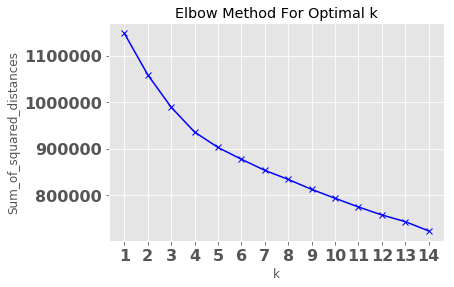

In [130]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

por metrica del codo se decide hacer un clustering con 4 grupos, donde se ve un cambio en la convergencia se decide la n

In [257]:
df_std.isnull().sum().value_counts()

0    137
dtype: int64

In [180]:
kmeans = KMeans(n_clusters=3, n_jobs=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=6, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [181]:
df_train = pd.concat([df_train, pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [182]:
 len(kmeans.predict(df_std))

8209

In [183]:
len(df_train)

7540

In [184]:
df_train["cluster"] = pd.DataFrame(kmeans.predict(df_std)).dropna()

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# AED

Text(0.5, 1.0, 'Histograma de variable predictiva')

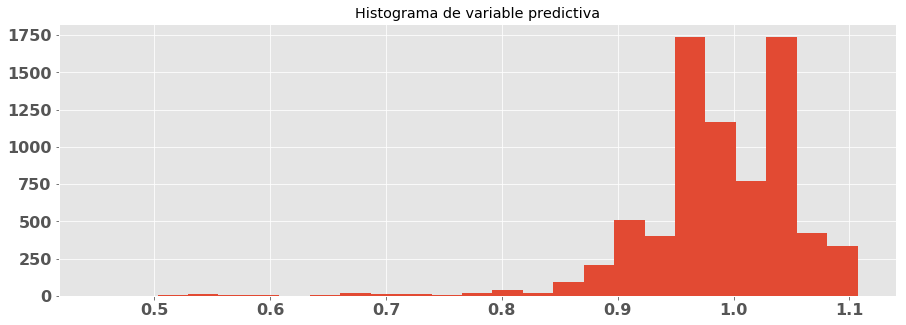

In [185]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
# plt.xticks(np.linspace(0,4000,15));

# Dispersiones

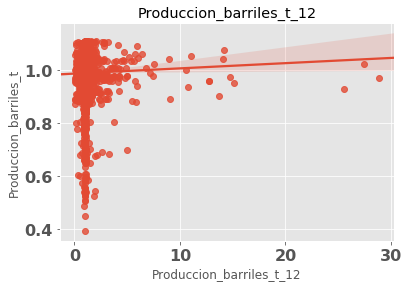

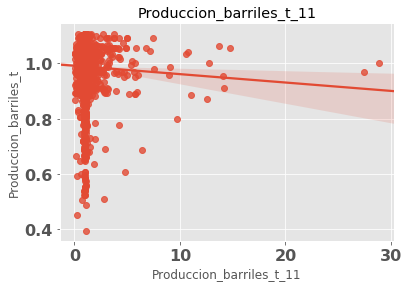

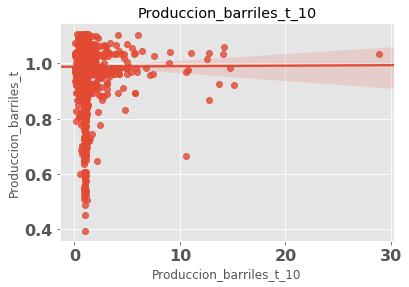

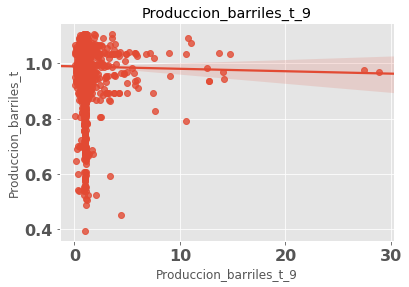

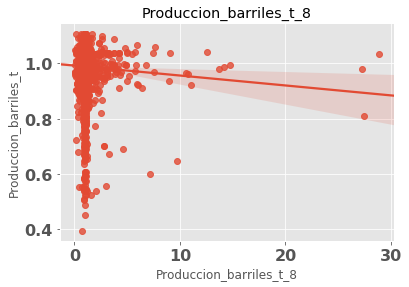

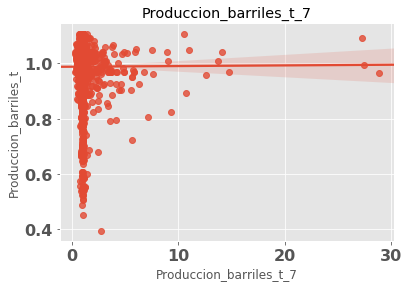

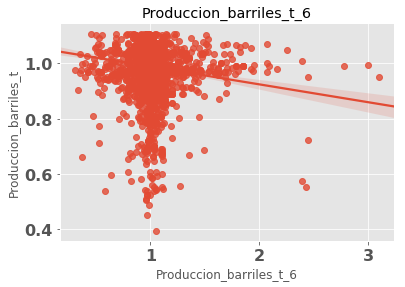

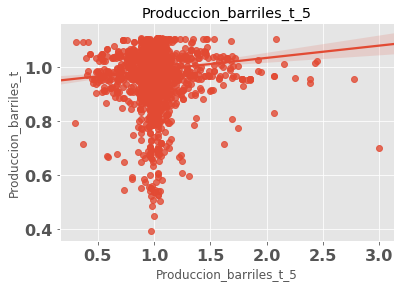

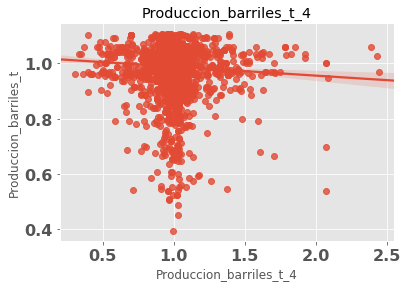

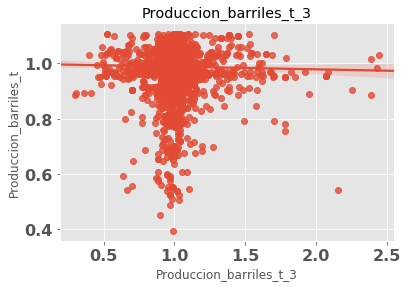

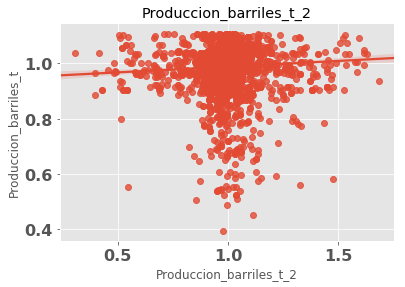

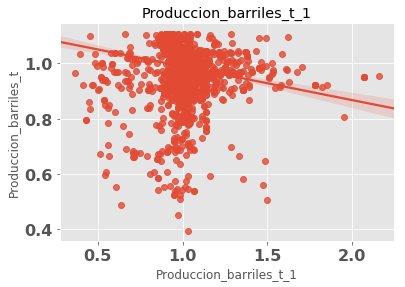

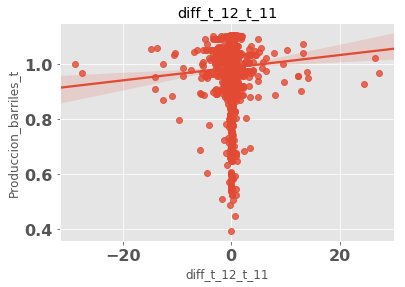

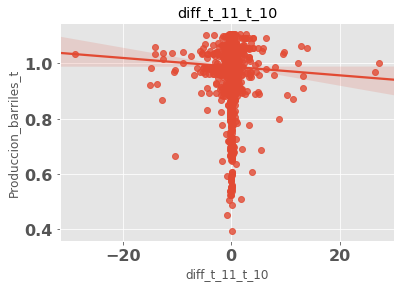

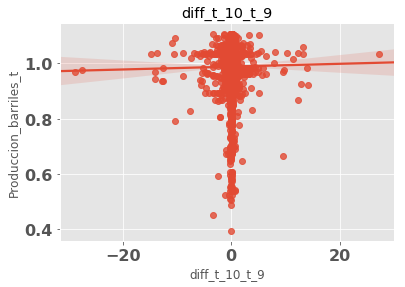

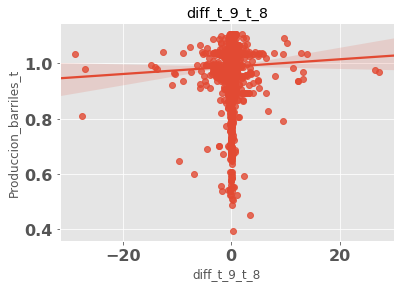

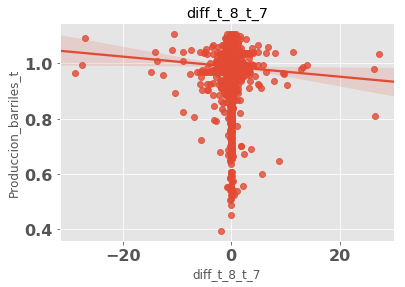

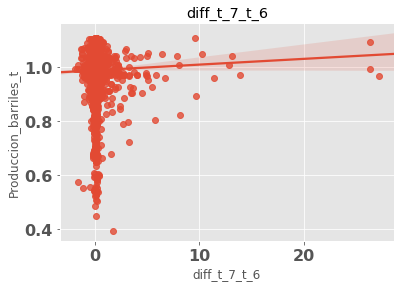

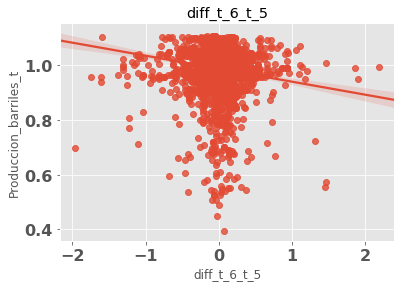

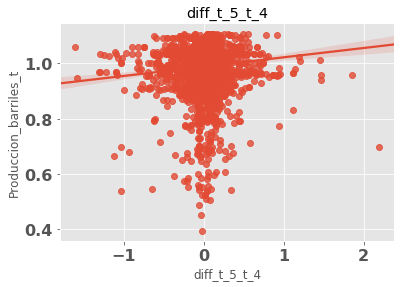

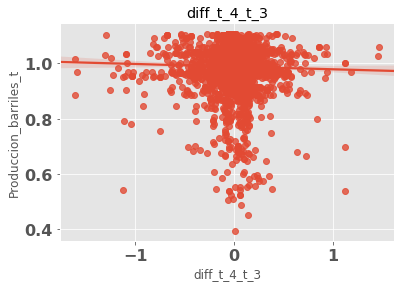

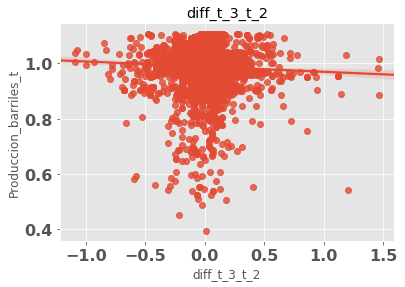

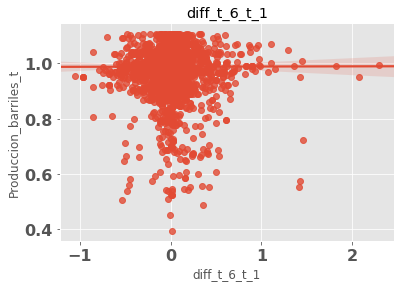

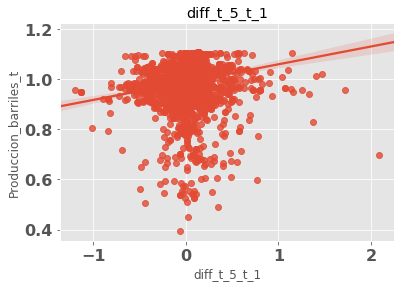

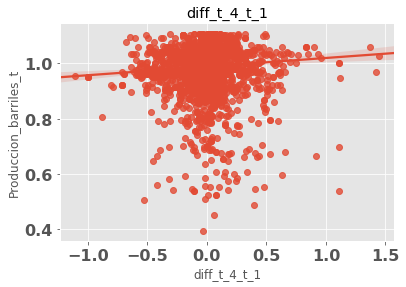

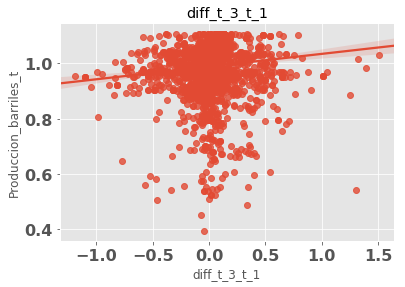

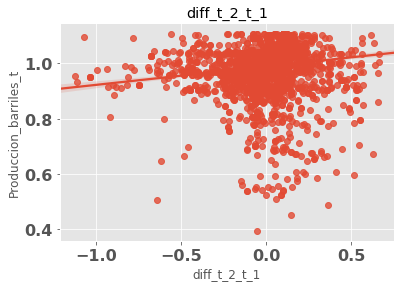

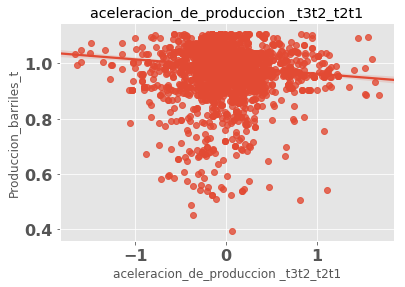

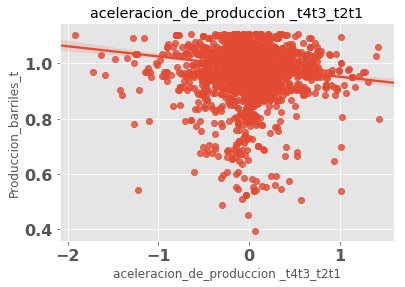

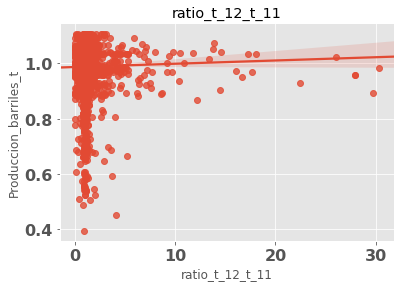

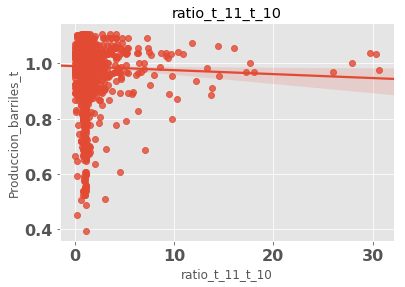

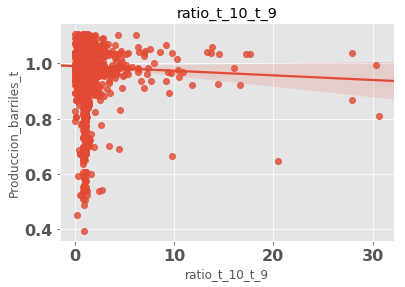

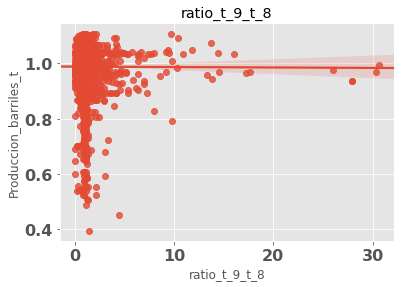

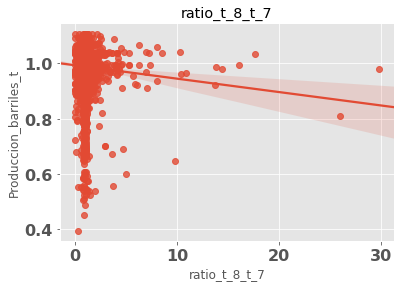

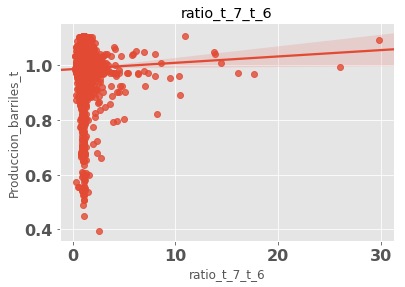

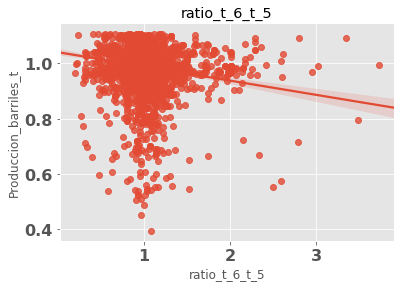

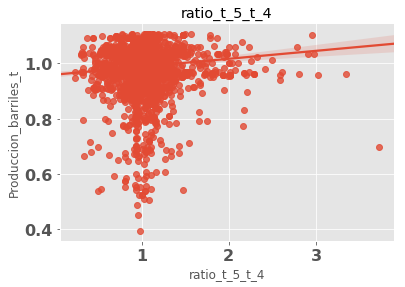

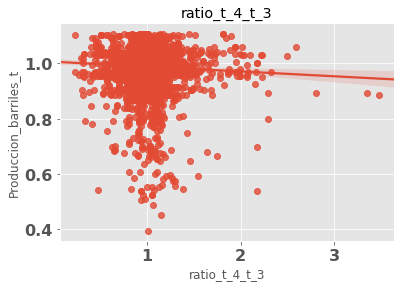

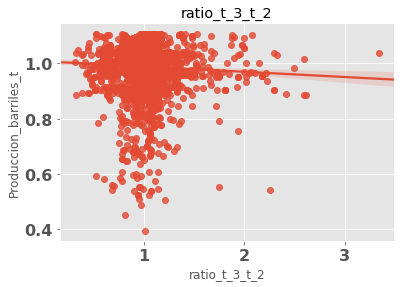

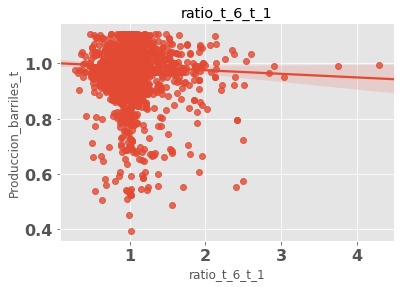

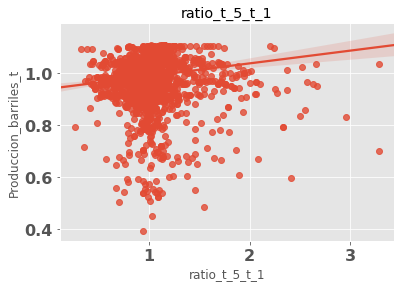

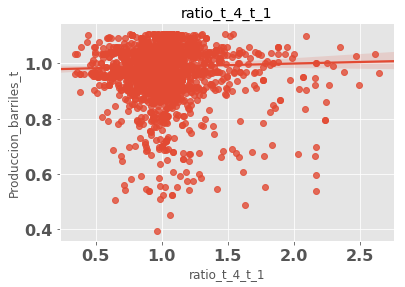

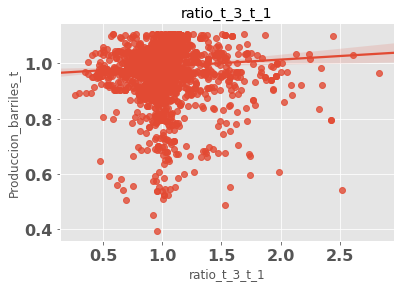

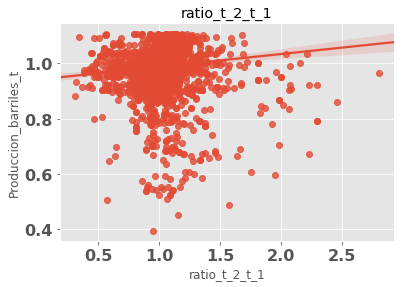

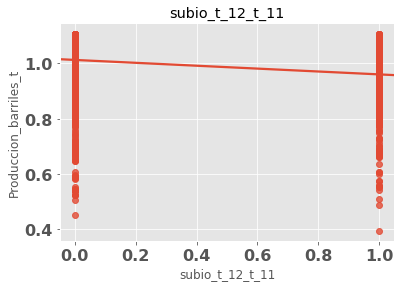

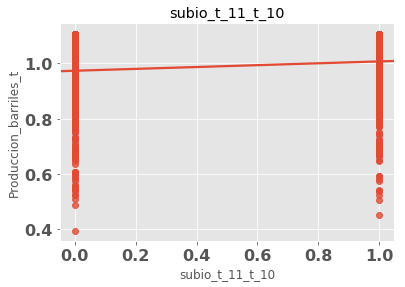

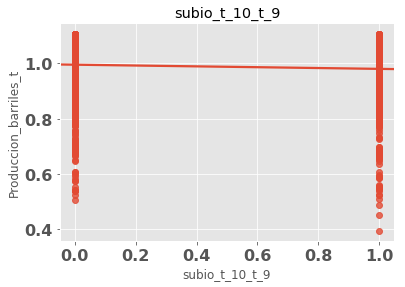

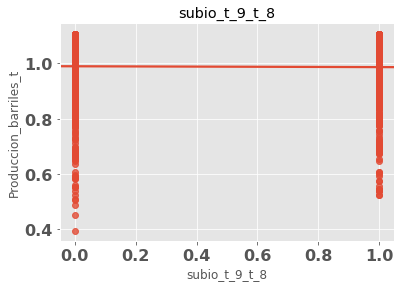

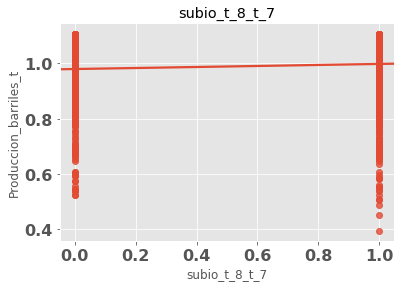

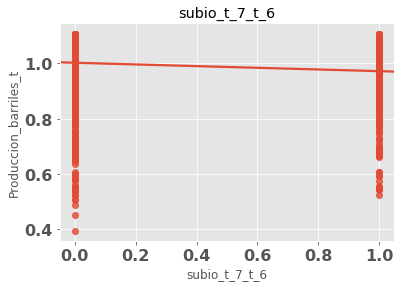

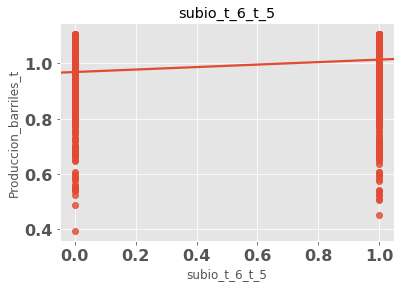

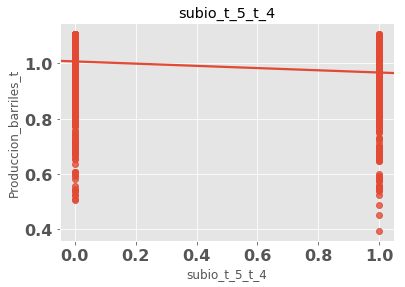

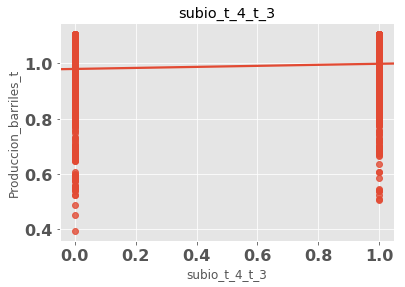

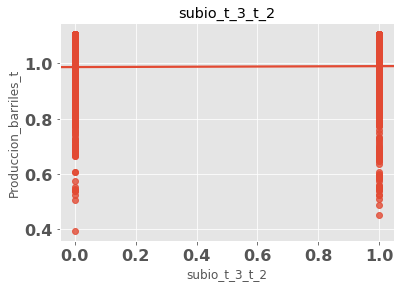

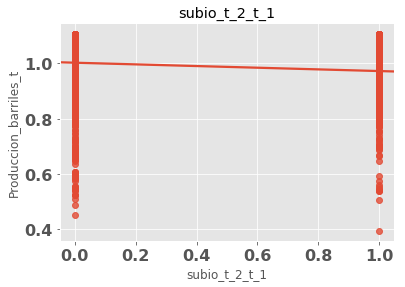

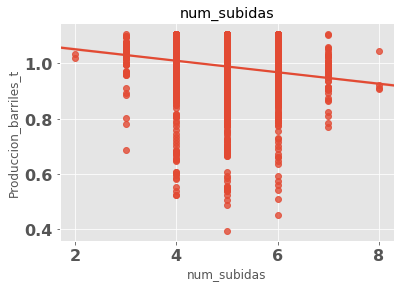

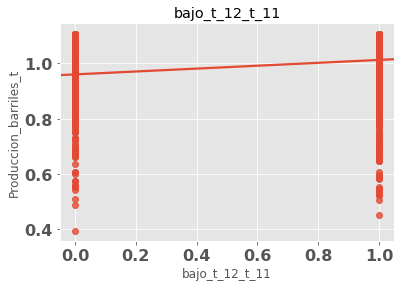

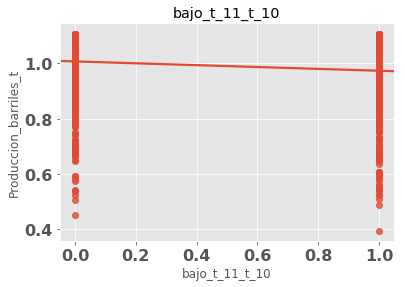

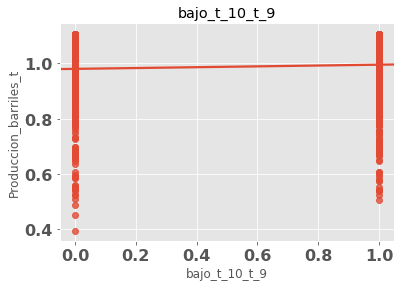

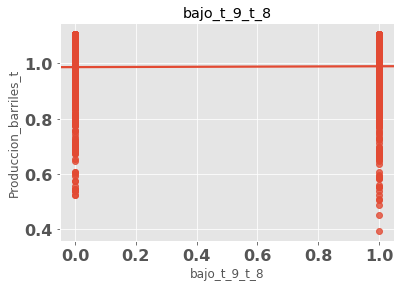

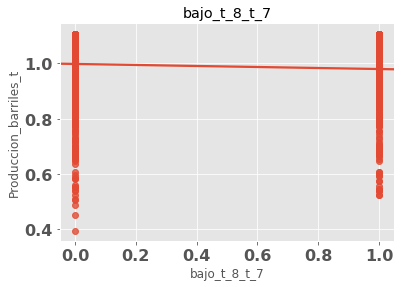

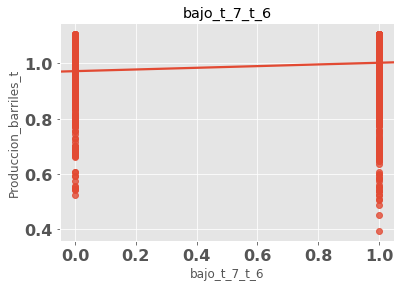

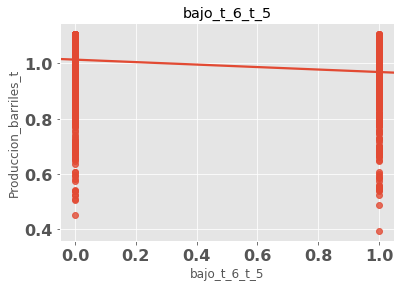

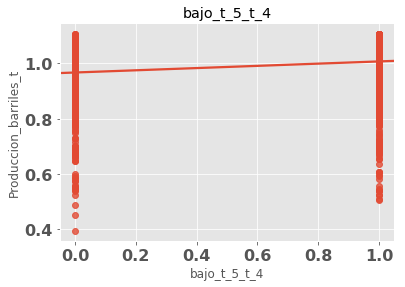

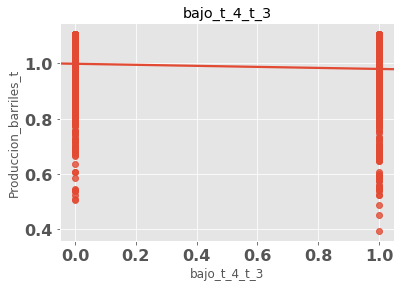

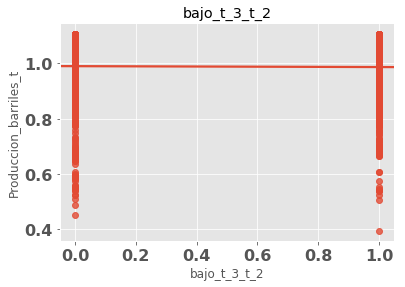

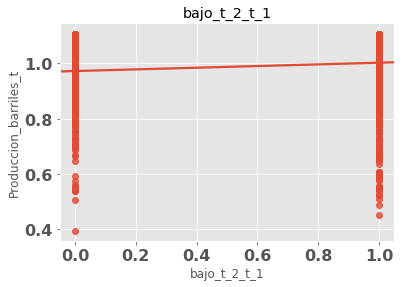

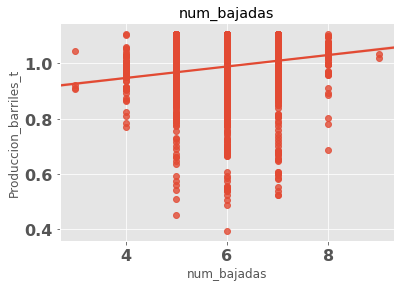

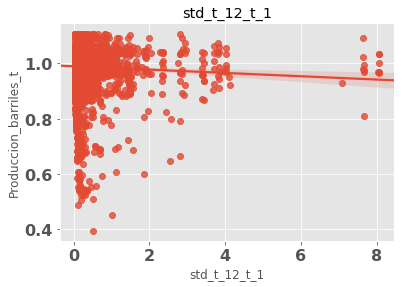

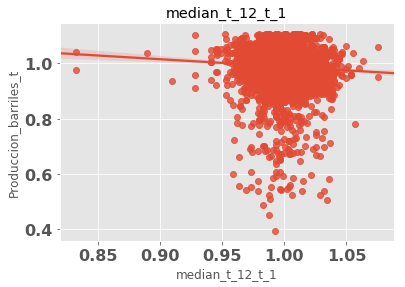

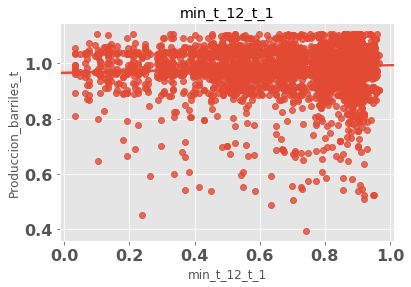

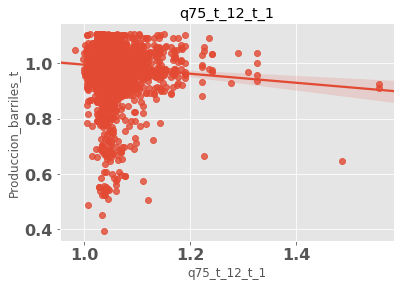

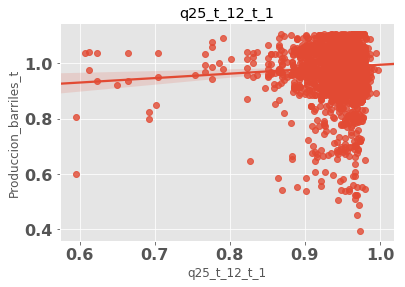

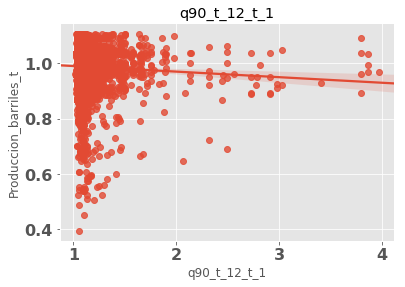

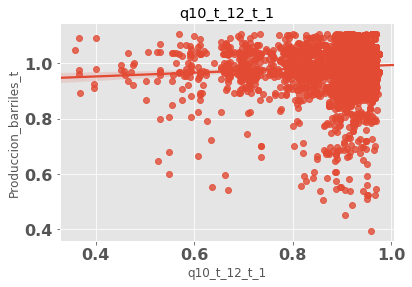

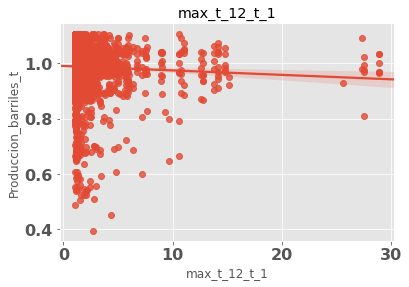

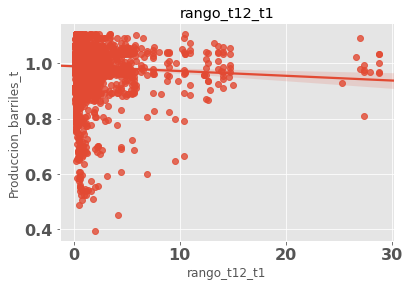

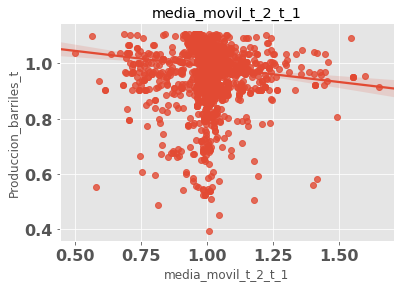

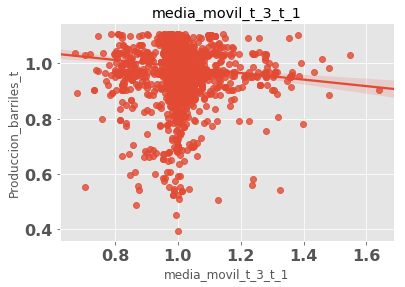

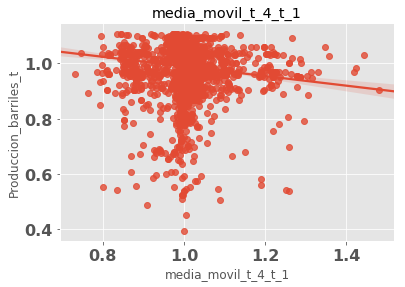

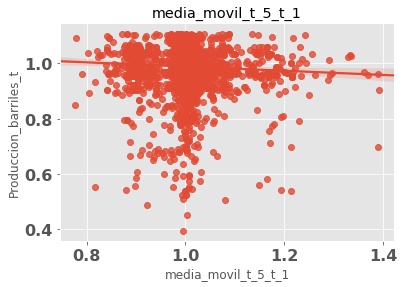

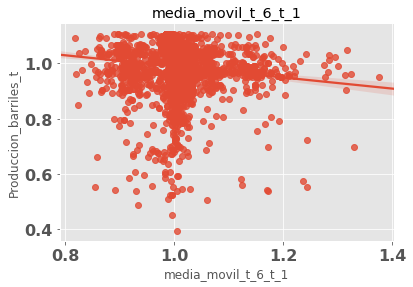

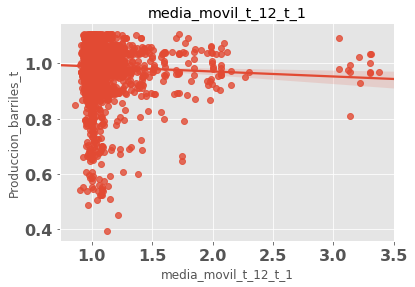

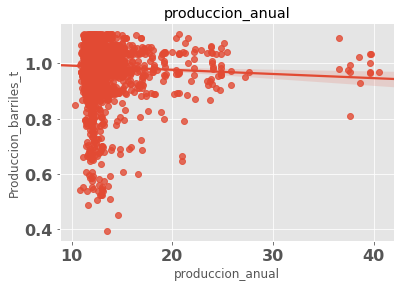

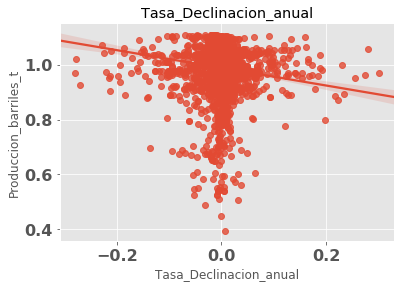

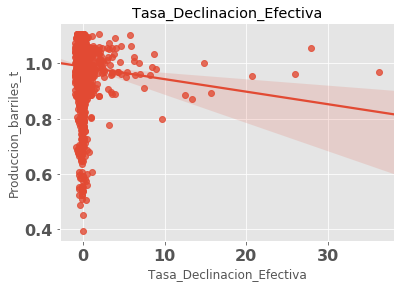

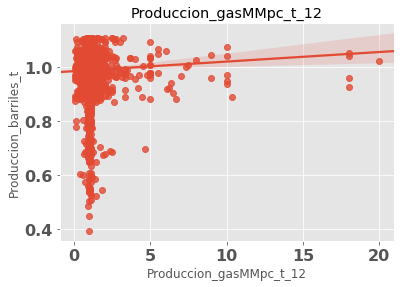

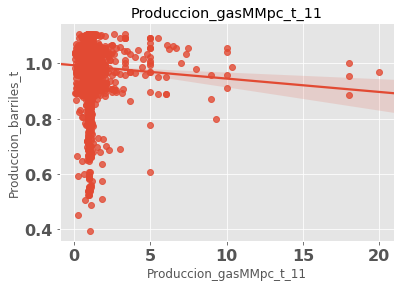

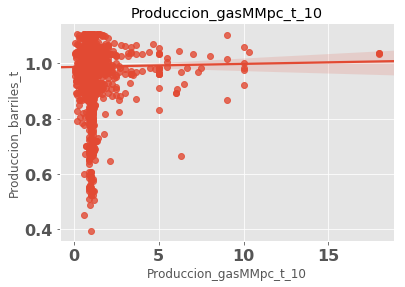

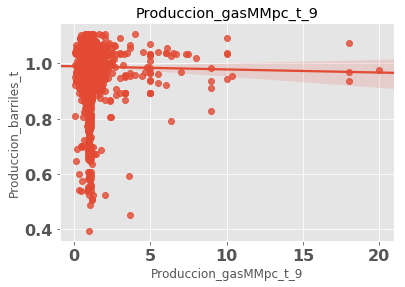

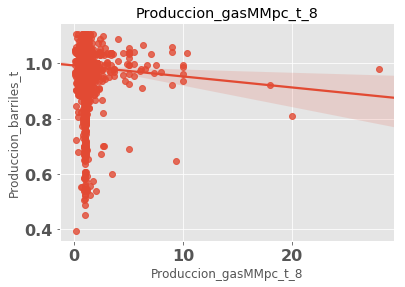

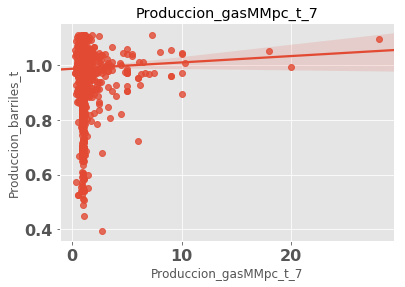

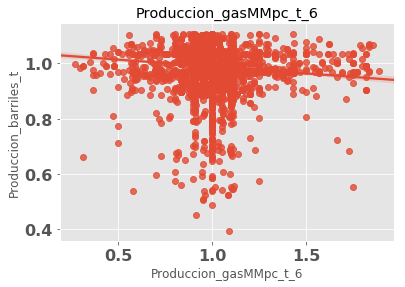

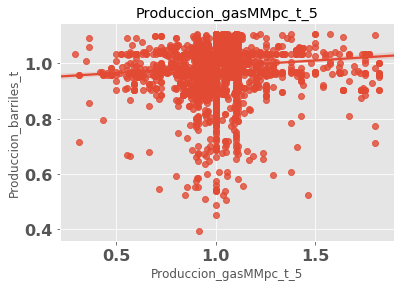

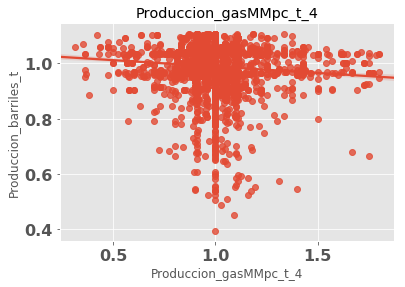

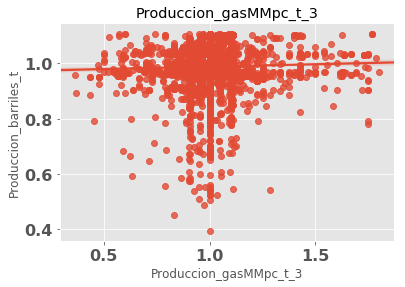

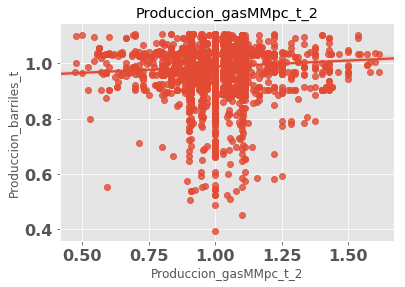

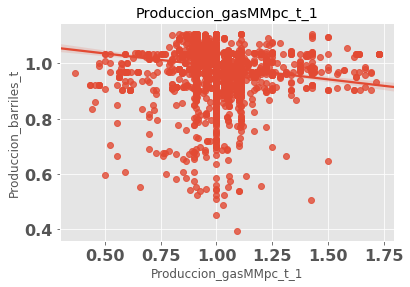

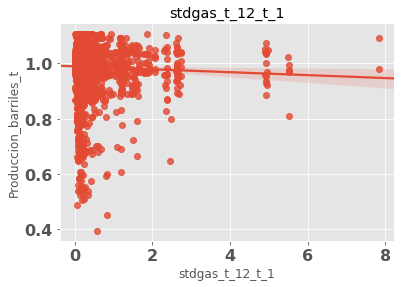

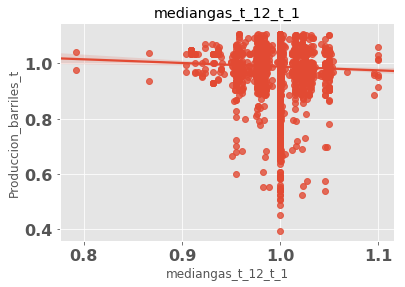

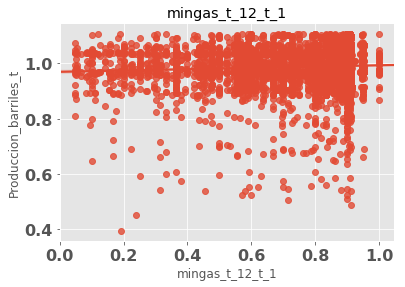

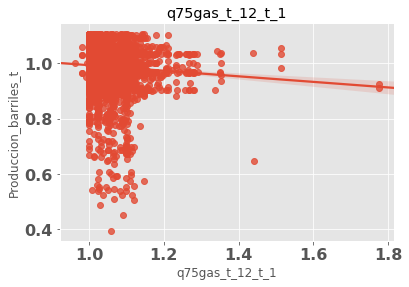

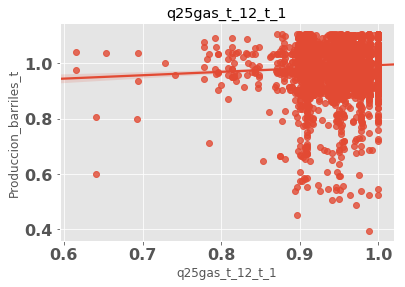

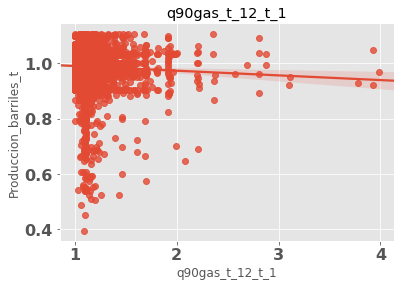

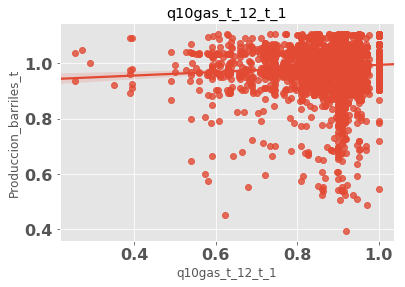

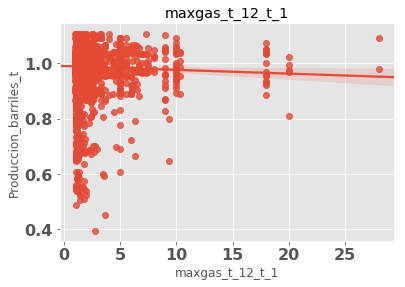

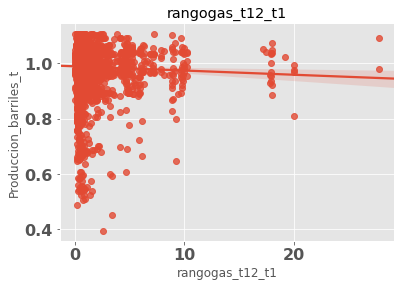

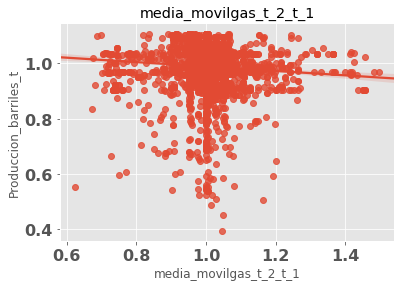

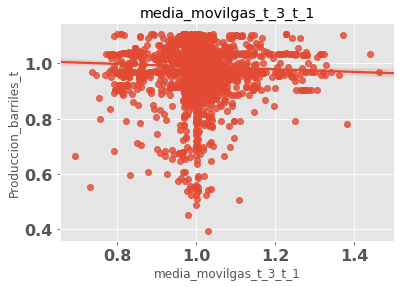

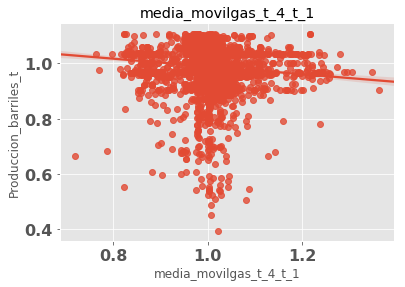

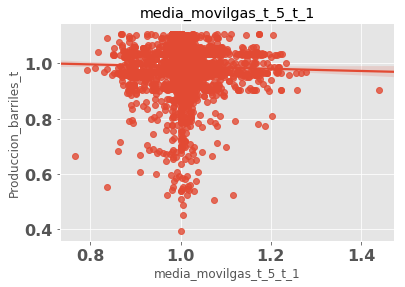

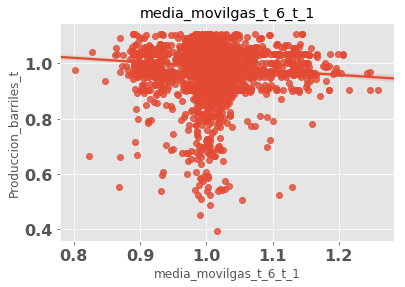

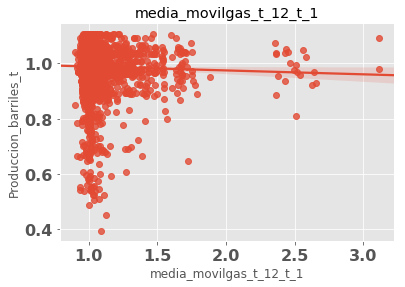

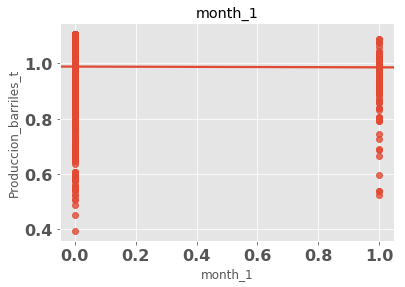

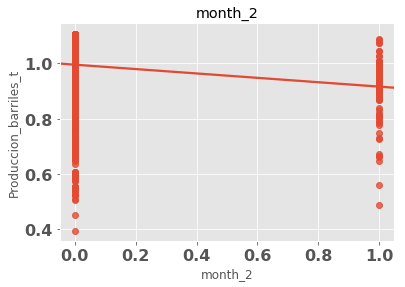

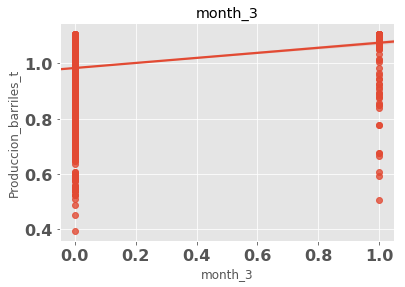

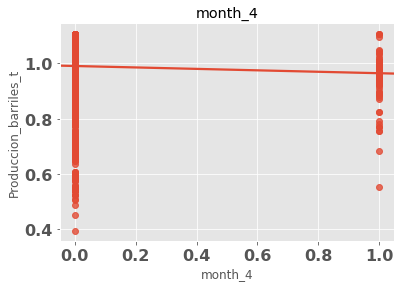

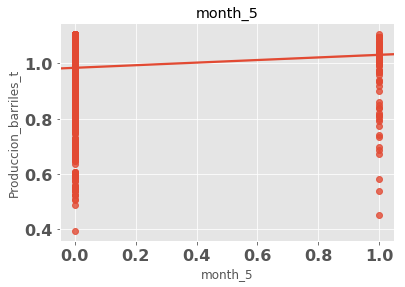

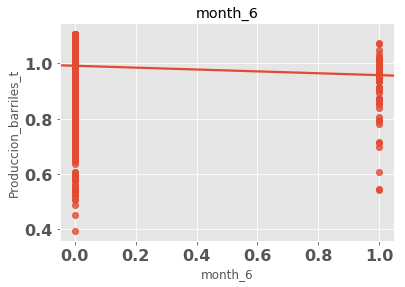

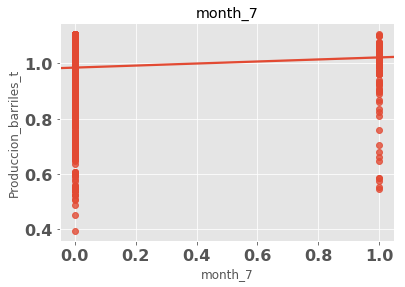

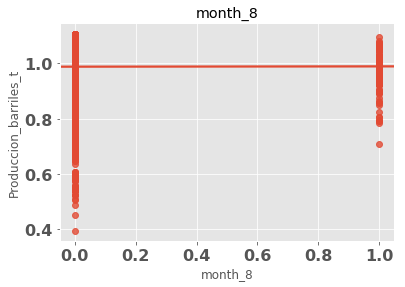

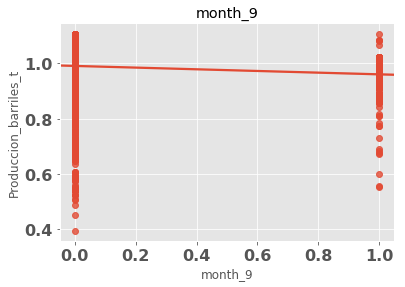

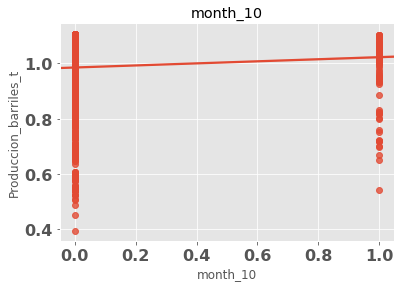

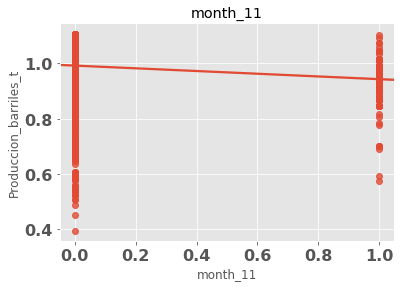

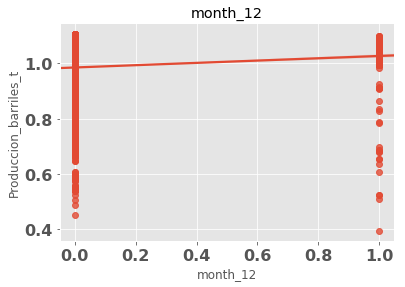

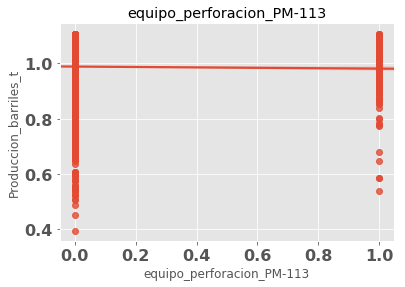

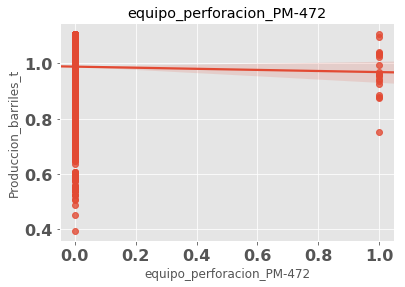

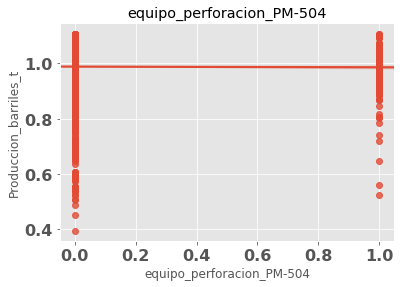

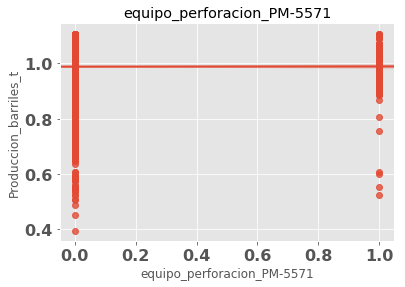

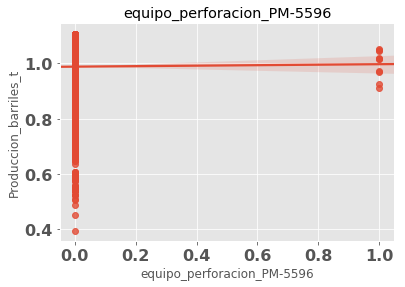

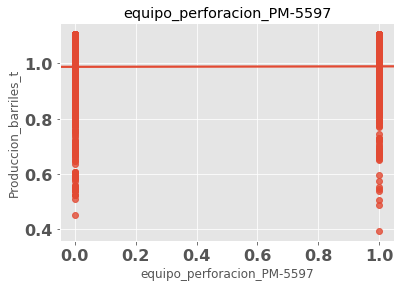

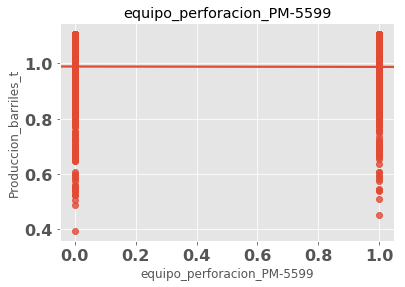

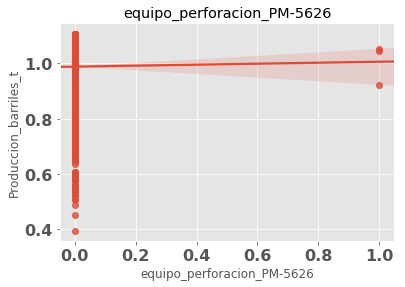

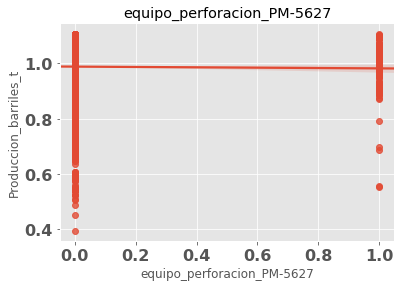

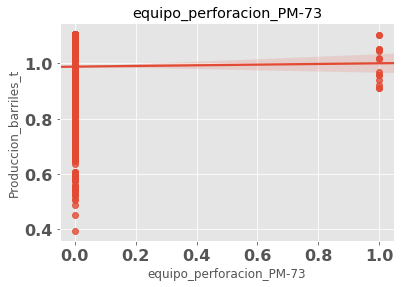

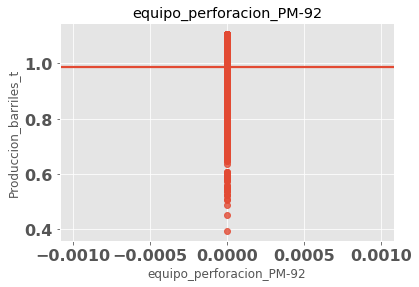

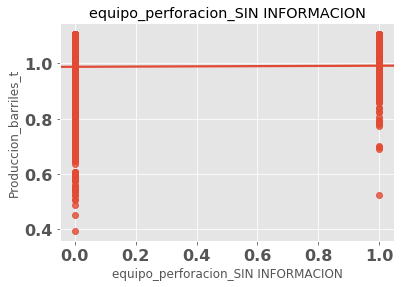

In [138]:
for i in num_cols:
    plt.subplots()
    sns.regplot(df_train[i],df_train.Produccion_barriles_t,)
    plt.title(i)

In [141]:
df_prod_heatmap = df_train.set_index('f_prod').groupby([
    'Pozo',pd.Grouper(freq='1Y')]).Produccion_barriles_t.sum()

Text(0.5, 1.0, 'Produccion anual por pozo, historia')

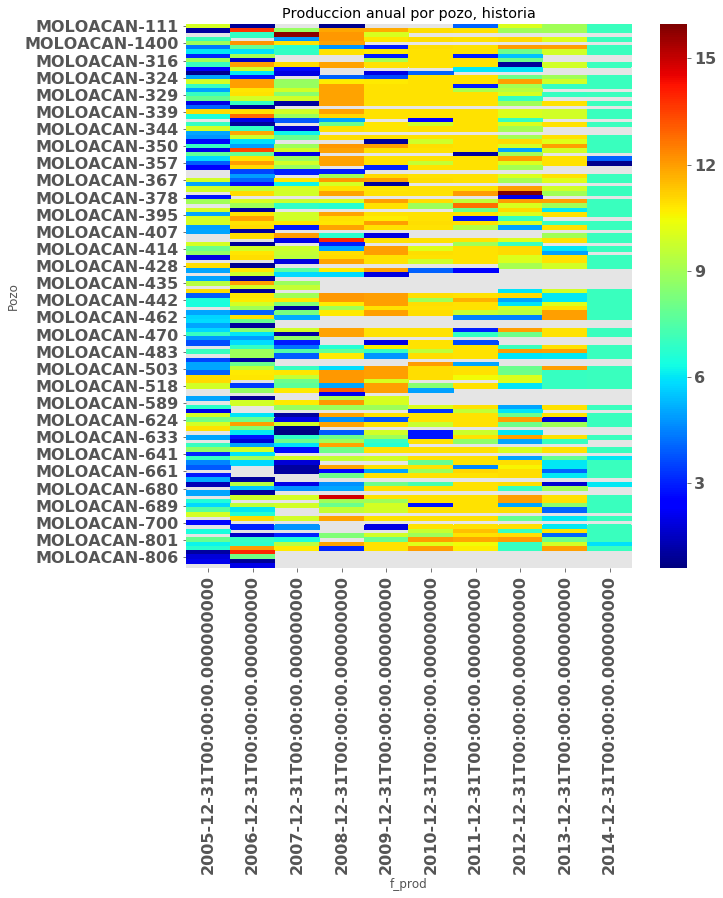

In [145]:
plt.figure(figsize=(10,10))
sns.heatmap(df_prod_heatmap.unstack(),cmap='jet')
plt.title('Produccion anual por pozo, historia')

# heatmap por produccion

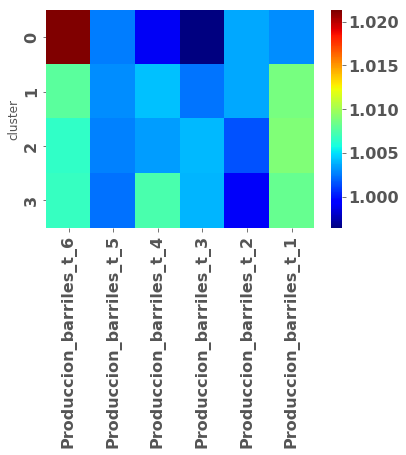

In [149]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
# plt.title('''Observamos que hay pozos estables en cantidad de produccion y
#             otros que ascienden o descienden en produccion''')

# mapa de correlaciones y grafico de correlacion con variable dependiente

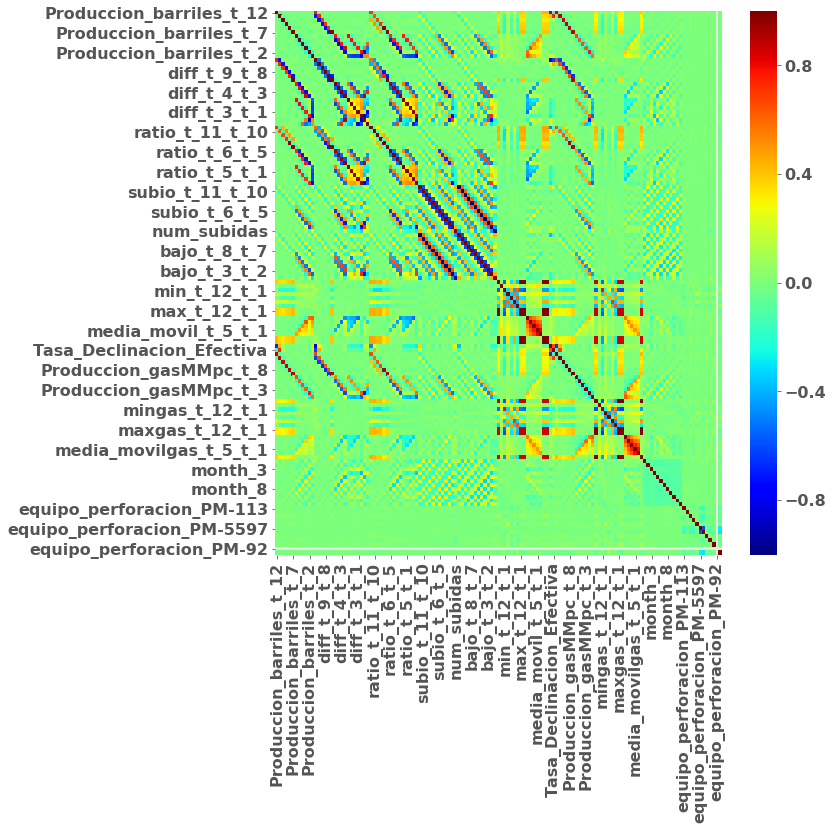

In [151]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train[num_cols].corr(),cmap='jet')

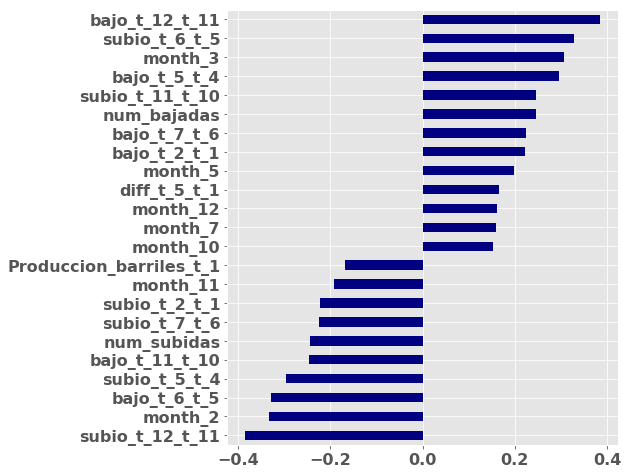

In [169]:
df_corr = df_train[num_cols].corrwith(df_train.Produccion_barriles_t).dropna().sort_values()

df_corr[df_corr.abs()>0.15].plot.barh(color='navy', figsize=(7,8))

In [174]:
df_train.describe().T

count        mean         std        min  \
Produccion_barriles_t_12            7691.0    1.056973    0.782442   0.033127   
Produccion_barriles_t_11            7691.0    1.057475    0.723352   0.033127   
Produccion_barriles_t_10            7691.0    1.054553    0.688767   0.033127   
Produccion_barriles_t_9             7691.0    1.057720    0.733836   0.033943   
Produccion_barriles_t_8             7691.0    1.054942    0.751984   0.033943   
Produccion_barriles_t_7             7691.0    1.061821    0.741716   0.297241   
Produccion_barriles_t_6             7691.0    1.007389    0.128259   0.305667   
Produccion_barriles_t_5             7691.0    1.002706    0.122975   0.297241   
Produccion_barriles_t_4             7691.0    1.004595    0.111804   0.305667   
Produccion_barriles_t_3             7691.0    1.003327    0.111603   0.297241   
Produccion_barriles_t_2             7691.0    1.001659    0.091526   0.305667   
Produccion_barriles_t_1             7691.0    1.008581    0.093824   0.364818   
Produccion_barriles_t               7691.0    0.988009    0.067618   0.396059   
y_real_oil_t_1                      7691.0  293.548277  161.227576  88.760000   
y_real_oil                          7691.0  289.256673  159.065466  72.780000   
diff_t_12_t_11                      7691.0   -0.000501    1.099141 -28.819295   
diff_t_11_t_10                      7691.0    0.002922    1.031287 -28.819295   
diff_t_10_t_9                       7691.0   -0.003167    1.041765 -28.819295   
diff_t_9_t_8                        7691.0    0.002778    1.081526 -28.819295   
diff_t_8_t_7                        7691.0   -0.006879    1.090518 -28.819295   
diff_t_7_t_6                        7691.0    0.054432    0.749769  -1.966716   
diff_t_6_t_5                        7691.0    0.004684    0.191670  -1.966716   
diff_t_5_t_4                        7691.0   -0.001889    0.180267  -1.614285   
diff_t_4_t_3                        7691.0    0.001267    0.172738  -1.614565   
diff_t_3_t_2                        7691.0    0.001668    0.158690  -1.093106   
diff_t_6_t_1                        7691.0   -0.001191    0.154984  -1.057222   
diff_t_5_t_1                        7691.0   -0.005875    0.157317  -1.199851   
diff_t_4_t_1                        7691.0   -0.003986    0.146218  -1.108638   
diff_t_3_t_1                        7691.0   -0.005253    0.144041  -1.190555   
diff_t_2_t_1                        7691.0   -0.006921    0.146348  -1.124884   
...                                    ...         ...         ...        ...   
month_1                             7691.0    0.082954    0.275831   0.000000   
month_2                             7691.0    0.089325    0.285231   0.000000   
month_3                             7691.0    0.054349    0.226720   0.000000   
month_4                             7691.0    0.089585    0.285605   0.000000   
month_5                             7691.0    0.090105    0.286351   0.000000   
month_6                             7691.0    0.093226    0.290768   0.000000   
month_7                             7691.0    0.094656    0.292758   0.000000   
month_8                             7691.0    0.086335    0.280876   0.000000   
month_9                             7691.0    0.085034    0.278951   0.000000   
month_10                            7691.0    0.083864    0.277202   0.000000   
month_11                            7691.0    0.076973    0.266566   0.000000   
month_12                            7691.0    0.073593    0.261124   0.000000   
equipo_perforacion_PM-113           7691.0    0.037966    0.191128   0.000000   
equipo_perforacion_PM-472           7691.0    0.002470    0.049645   0.000000   
equipo_perforacion_PM-504           7691.0    0.040697    0.197600   0.000000   
equipo_perforacion_PM-5571          7691.0    0.030555    0.172120   0.000000   
equipo_perforacion_PM-5596          7691.0    0.001300    0.036037   0.000000   
equipo_perforacion_PM-5597          7691.0    0.363022    0.480902  

quitar por que no hay registros con esta tecnologia 'equipo_perforacion_PM-78','equipo_perforacion_PM-92'

# Entrenamiento

In [187]:
df_train.reset_index(inplace=True,drop=True)

In [188]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','equipo_perforacion_PM-78','equipo_perforacion_PM-92','cluster','y_real_oil_t_1', 
            'y_real_oil', 'f_prod', 'latitud', 'longitud','y_real_gas_t_1', 'y_real_gas']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'produccion_anual',
 'Tasa_Declinacion_anual',
 'Tasa_Declinacion_Efectiva',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3']

# Se entrena con un cross_validation temporal
+ train 108 meses 
    + fecha inicio 2005-01-01 
    + fecha fin 2013-05-01
+ test 7.2 meses 
    + fecha inicio 2013-05-01 
    + fecha fin 2014-01-01
+ valid 7.2 meses 
    + fecha inicio 2014-01-01 
    + fecha fin 2014-07-01

In [284]:
x_train = df_train[df_train.f_prod <= pd.to_datetime('2013-05-01')][num_cols]
y_train = df_train[df_train.f_prod < pd.to_datetime('2013-05-01')]['Produccion_barriles_t']
    
x_test = df_train[df_train.set_index('f_prod').between_time(
    pd.to_datetime('2013-05-01'), pd.to_datetime('2014-01-01'),include_end=False)][num_cols]
y_test = df_train[df_train.set_index('f_prod').between_time(
    pd.to_datetime('2013-05-01'), pd.to_datetime('2014-01-01') ,include_end=False)]['Produccion_barriles_t']

x_valid = df_train[df_train.f_prod >= pd.to_datetime('2014-01-01')][num_cols]
y_valid = df_train[df_train.f_prod >= pd.to_datetime('2014-01-01')]['Produccion_barriles_t']


# 3-cross validation

In [189]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
        num_cols, 'Produccion_barriles_t')

In [190]:
x_train.shape

(5428, 140)

Se entrena con 140 variables

In [179]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2245]	valid_0's l1: 0.0174729


In [180]:
clf.num_trees()

2245

# Evaluacion

Para tener una evaluacion real hay que regresar a los valores de produccion, debido a que se hizo la regresion sobre el cociente entre t y t-1

In [182]:
y_pred = df_train.iloc[x_valid.index].y_real_oil_t_1 * clf.predict(x_valid)
y_real = df_train.iloc[x_valid.index].y_real_oil_t_1 * y_valid

In [183]:
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))

In [184]:
report_evaluation_regression(y_real, y_pred, x_train.shape[1])

R^2: 0.9854
R^2 ajustada$: 0.9821
MEA: 6.1108
MSE 371.8908
RMSE 19.2845


In [185]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

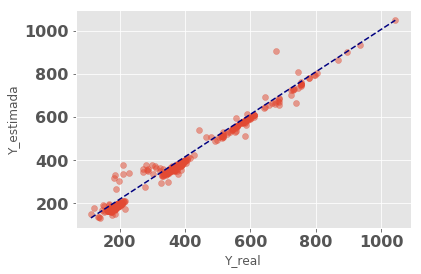

In [186]:
yy_plot(y_real, y_pred)

## Residuos

In [187]:
res = (y_real - y_pred) / y_real

Mediana del residuo porcentual 0.101
Residuo porcentual promedio -0.556


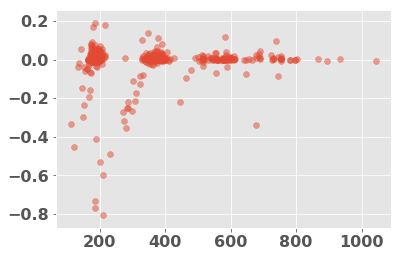

In [192]:
plt.scatter(y_real, res, alpha=0.5)
res_median = res.median() * 100
res_promedio = res.mean() * 100
print("Mediana del residuo porcentual %1.3f" % res_median)
print("Residuo porcentual promedio %1.3f" % res_promedio)

### check de correlacion entre residuos
No tiene que tener correlacion

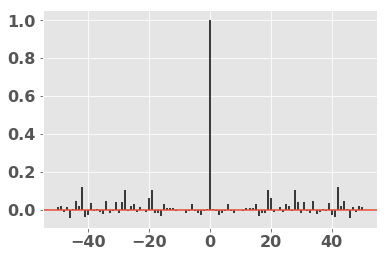

In [193]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

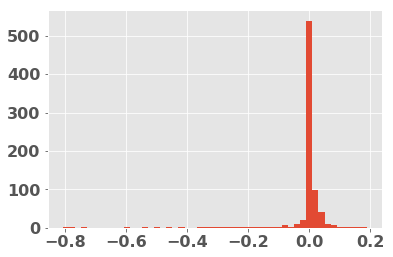

In [195]:
# check de histograma de residuos
# tienen que distribuirse como una normal
res.hist(bins=50)

# Interpretacion

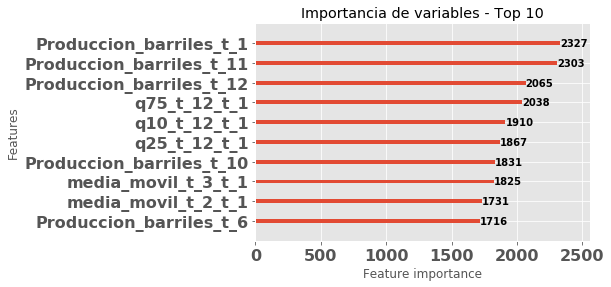

In [196]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [197]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [202]:
shap.initjs()

In [203]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales
Los efectos marginales es el cambio en la prediccion con respecto a cada variable, calculando el promedio de todas las demas variable y solamente cambiando por quantiles la variable seleccionada para observar el impacto promedio de la variable.

Recuerda que la interpretacion del efecto marginal esta en terminos de $\frac{y(t)}{y(t-1)}$

In [199]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [200]:
a.tail(8).index

Index(['media_movil_t_3_t_1', 'Produccion_barriles_t_10', 'q25_t_12_t_1',
       'q10_t_12_t_1', 'q75_t_12_t_1', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_1'],
      dtype='object')

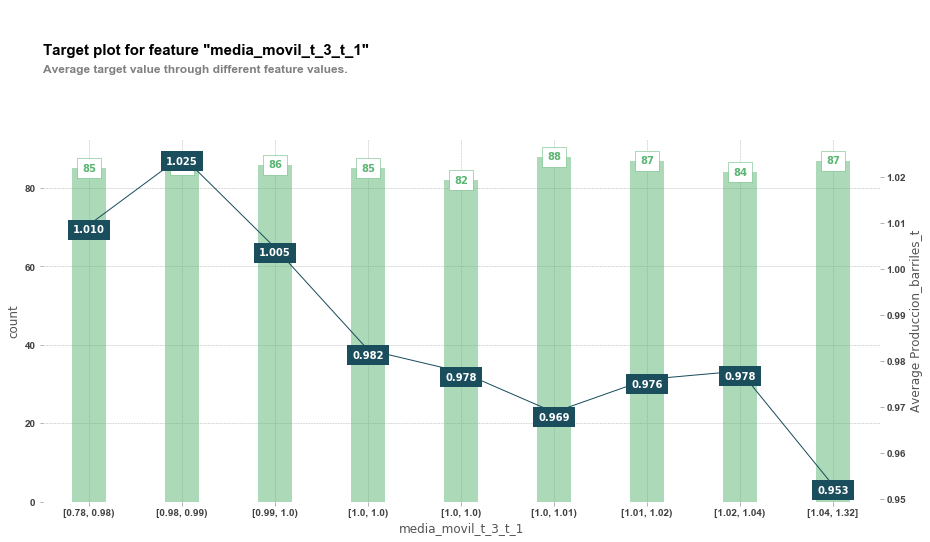

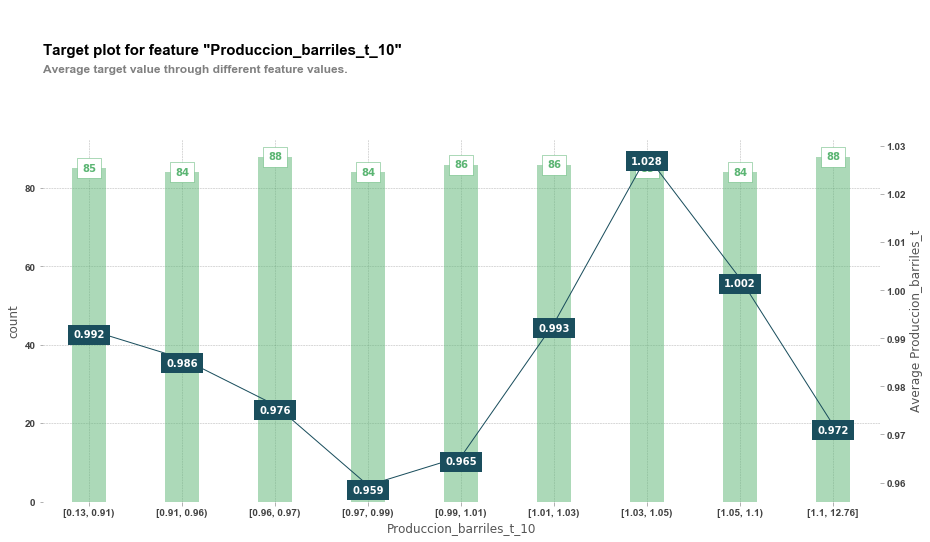

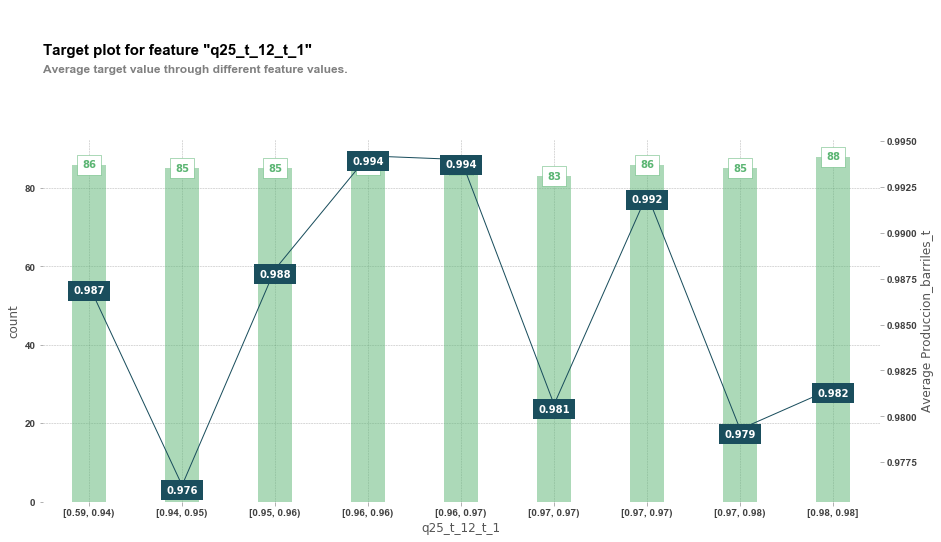

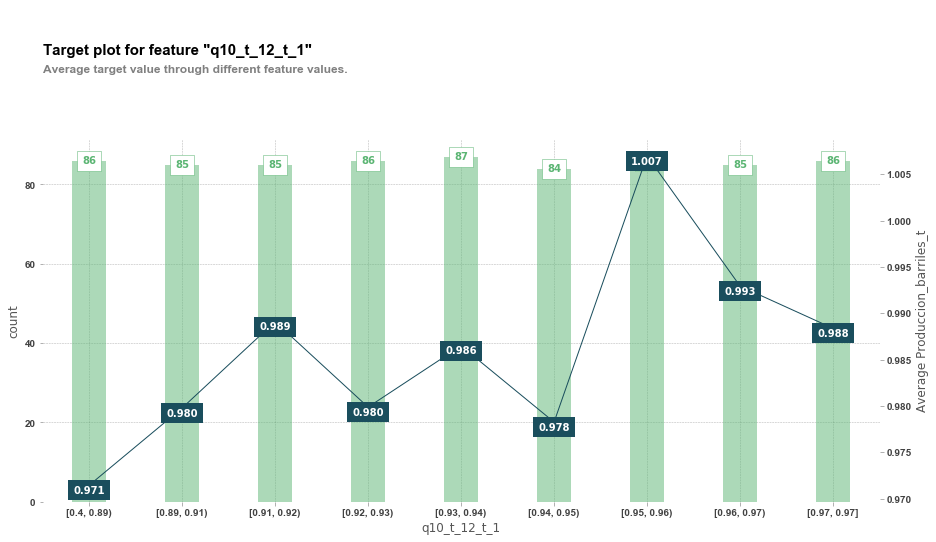

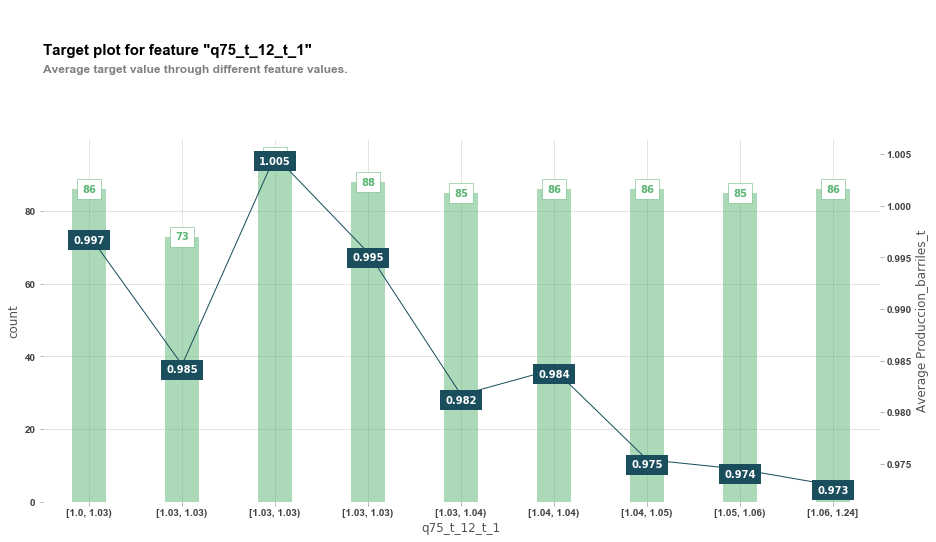

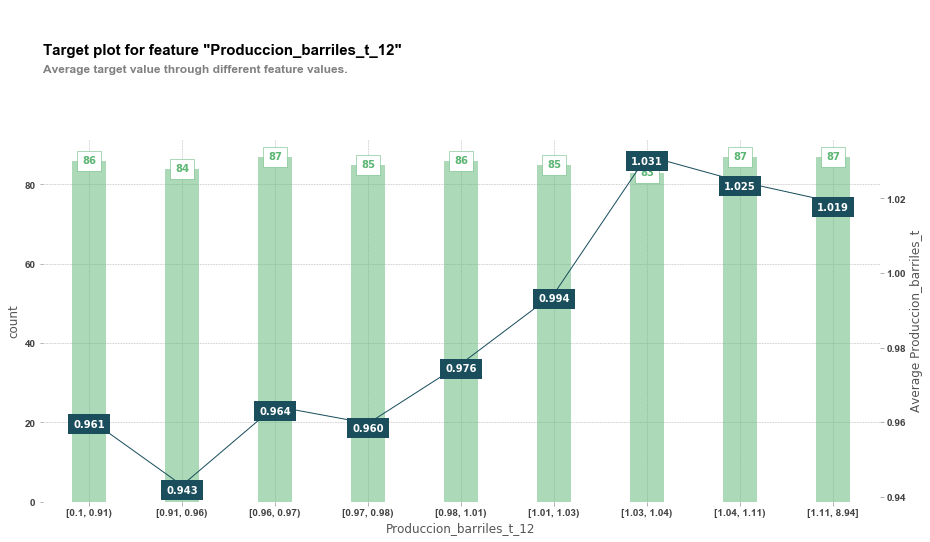

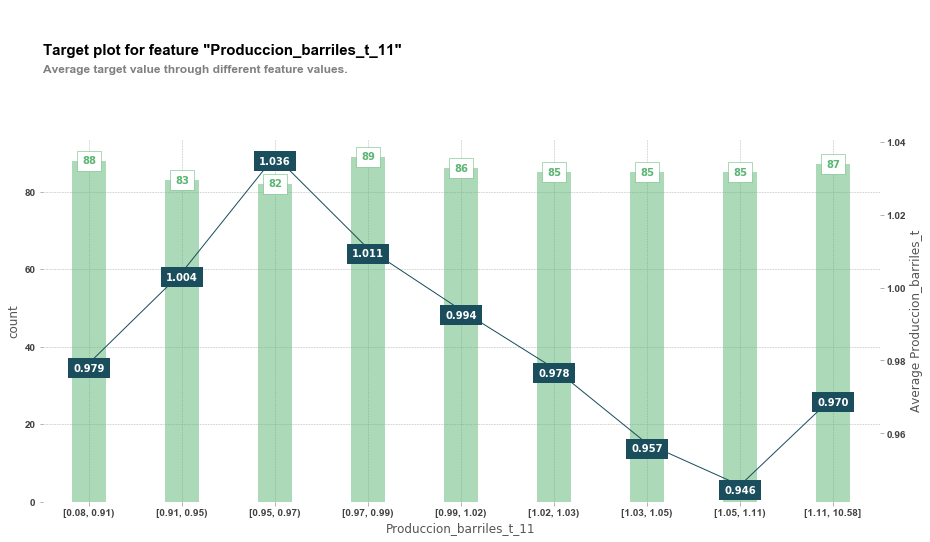

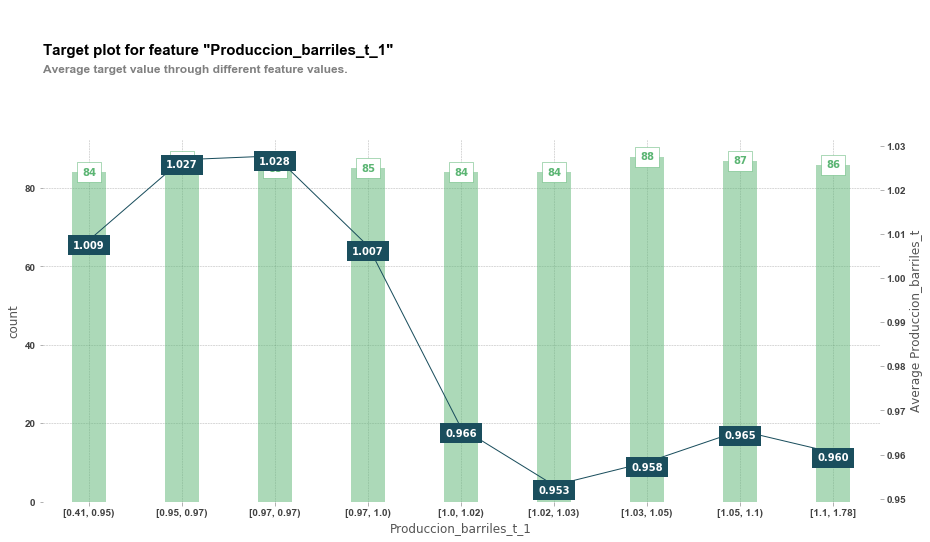

In [201]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        ,feature=col, 
        feature_name=col, 
        target='Produccion_barriles_t'
    )

## Pendiente interpretar los de shap

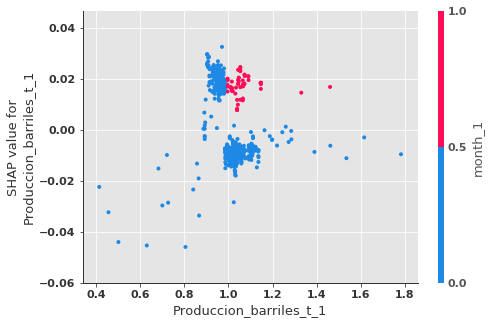

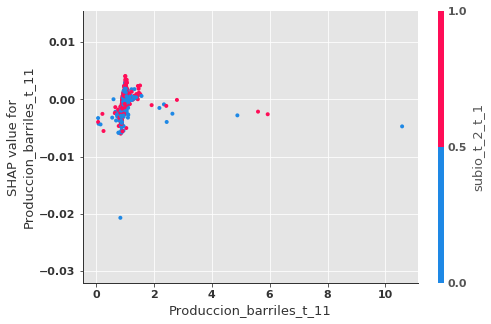

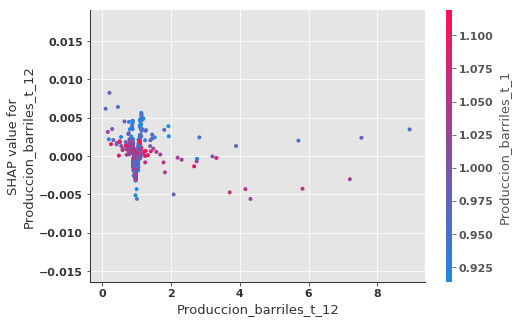

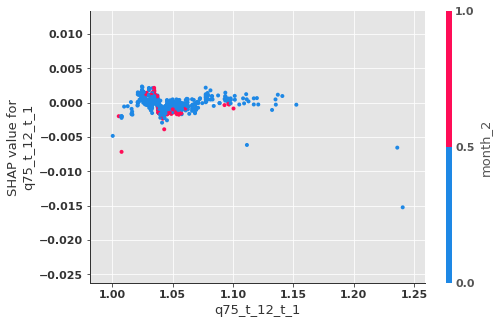

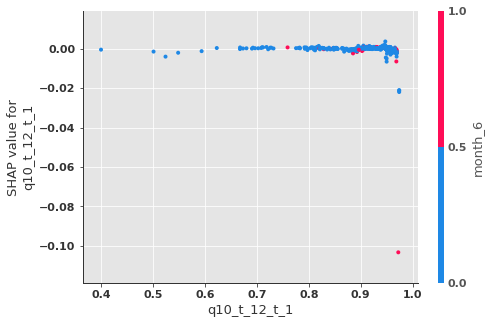

In [204]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [207]:
joblib.dump(clf, 'light_gbm_oil_05-08-2019.pkl')

['light_gbm_oil_05-08-2019.pkl']

In [192]:
# carga de modelo
gbm_pickle = joblib.load('light_gbm_oil_05-08-2019.pkl')

In [204]:
clf = gbm_pickle

# Check de pozos aleatorios

In [205]:
# idx = df_train.Pozo.sample(10)

In [206]:
# index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [207]:
# validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [208]:
# prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [209]:
# prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

In [210]:
# ax = validacion.plot(figsize=(17,9),color='navy')
# prediccion_validacion.plot(ax = ax,color='cyan')

In [211]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [212]:
preds = df_train.y_real_oil_t_1 * clf.predict(df_train[num_cols])
real = df_train.y_real_oil

In [213]:
df_train['prediction_oil'] = preds

In [214]:
df_train['fecha_produccion'] = df_train.f_prod

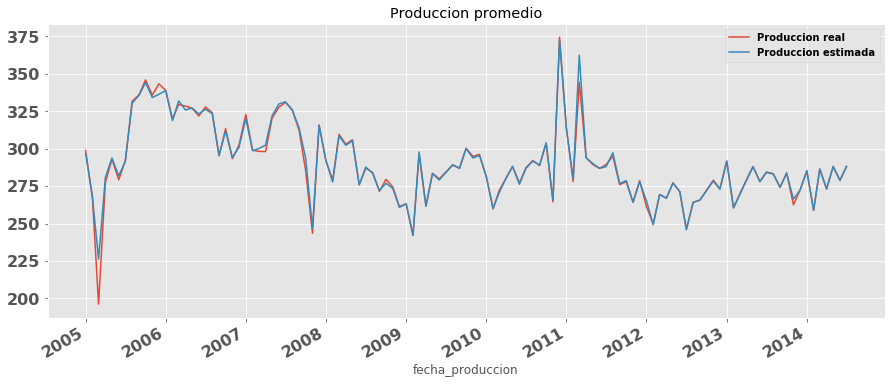

In [215]:
df_train.groupby('fecha_produccion')[['y_real_oil','prediction_oil']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [227]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

70.0

In [229]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 60].index

In [230]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [231]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [235]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2005-01-01'].index

In [236]:
idx_a

Index(['MOLOACAN-454', 'MOLOACAN-468', 'MOLOACAN-483', 'MOLOACAN-515',
       'MOLOACAN-624', 'MOLOACAN-656', 'MOLOACAN-667'],
      dtype='object', name='Pozo')

In [237]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [242]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['y_real_oil','prediction_oil']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['y_real_oil'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['y_real_oil'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_oil'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_oil'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.y_real_oil - df_vivos2.prediction_oil

In [243]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [160]:
# df_vivos2.to_csv("perfiles_pozo.csv")

# Forecasting

In [218]:
for i,val in enumerate(df_train.columns):
    print(i,val)

0 Pozo
1 f_prod
2 Produccion_barriles_t_12
3 Produccion_barriles_t_11
4 Produccion_barriles_t_10
5 Produccion_barriles_t_9
6 Produccion_barriles_t_8
7 Produccion_barriles_t_7
8 Produccion_barriles_t_6
9 Produccion_barriles_t_5
10 Produccion_barriles_t_4
11 Produccion_barriles_t_3
12 Produccion_barriles_t_2
13 Produccion_barriles_t_1
14 Produccion_barriles_t
15 y_real_oil_t_1
16 y_real_oil
17 diff_t_12_t_11
18 diff_t_11_t_10
19 diff_t_10_t_9
20 diff_t_9_t_8
21 diff_t_8_t_7
22 diff_t_7_t_6
23 diff_t_6_t_5
24 diff_t_5_t_4
25 diff_t_4_t_3
26 diff_t_3_t_2
27 diff_t_6_t_1
28 diff_t_5_t_1
29 diff_t_4_t_1
30 diff_t_3_t_1
31 diff_t_2_t_1
32 aceleracion_de_produccion _t3t2_t2t1
33 aceleracion_de_produccion _t4t3_t2t1
34 ratio_t_12_t_11
35 ratio_t_11_t_10
36 ratio_t_10_t_9
37 ratio_t_9_t_8
38 ratio_t_8_t_7
39 ratio_t_7_t_6
40 ratio_t_6_t_5
41 ratio_t_5_t_4
42 ratio_t_4_t_3
43 ratio_t_3_t_2
44 ratio_t_6_t_1
45 ratio_t_5_t_1
46 ratio_t_4_t_1
47 ratio_t_3_t_1
48 ratio_t_2_t_1
49 subio_t_12_t_11
50 s

In [219]:
df_train.iloc[-1,15]

779.94

In [238]:
def forecast_pozos(df_pozos, num_cols, algoritmo, inicio = 0, fin = 5, lag = 12):
    """Realiza forecasting para una lista de pozos.
    
    Parametros:
    df_pozos -- Lista de pozos para realizar forecasting
    num_cols -- Variables a utilizar en el algoritmo
    algoritmo - Algoritmo a utilizar (p.ej., clf)
    
    Return:
    df_pred -- DataFrame con las predicciones de cada pozo
    
    Variables:
    pozos -- Cantidad de pozos en la lsita
    
    Funciones auxiliares:
    gen_cols(df) -. Calcula las variables
    forecast(df, n_pred , num_cols, algoritmo, columna_inicial = 2, lag =7) - Realiza el forecast
    """
    if fin == 'all':
        fin = df_pozos.shape[0]
        
    def gen_cols(df):
        """Calculo de variables
        """
    
        df['diff_t_12_t_11'] = df.Produccion_barriles_t_12 - df.Produccion_barriles_t_11
        df['diff_t_11_t_10'] = df.Produccion_barriles_t_11 - df.Produccion_barriles_t_10
        df['diff_t_10_t_9'] = df.Produccion_barriles_t_10 - df.Produccion_barriles_t_9
        df['diff_t_9_t_8'] = df.Produccion_barriles_t_9 - df.Produccion_barriles_t_8
        df['diff_t_8_t_7'] = df.Produccion_barriles_t_8 - df.Produccion_barriles_t_7
        df['diff_t_7_t_6'] = df.Produccion_barriles_t_7 - df.Produccion_barriles_t_6
        df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
        df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
        df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
        df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2

        # cambio en la produccion
        df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
        df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
        df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
        df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1
        df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1


        df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
        df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
        
        
        df['ratio_t_12_t_11'] = df.Produccion_barriles_t_12 / df.Produccion_barriles_t_11
        df['ratio_t_11_t_10'] = df.Produccion_barriles_t_11 / df.Produccion_barriles_t_10
        df['ratio_t_10_t_9'] = df.Produccion_barriles_t_10 / df.Produccion_barriles_t_9
        df['ratio_t_9_t_8'] = df.Produccion_barriles_t_9 / df.Produccion_barriles_t_8
        df['ratio_t_8_t_7'] = df.Produccion_barriles_t_8 / df.Produccion_barriles_t_7
        df['ratio_t_7_t_6'] = df.Produccion_barriles_t_7 / df.Produccion_barriles_t_6
        df['ratio_t_6_t_5'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_5
        df['ratio_t_5_t_4'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_4
        df['ratio_t_4_t_3'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_3
        df['ratio_t_3_t_2'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_2

        # cambio en la produccion
        df['ratio_t_6_t_1'] = df.Produccion_barriles_t_6 / df.Produccion_barriles_t_1
        df['ratio_t_5_t_1'] = df.Produccion_barriles_t_5 / df.Produccion_barriles_t_1
        df['ratio_t_4_t_1'] = df.Produccion_barriles_t_4 / df.Produccion_barriles_t_1
        df['ratio_t_3_t_1'] = df.Produccion_barriles_t_3 / df.Produccion_barriles_t_1
        df['ratio_t_2_t_1'] = df.Produccion_barriles_t_2 / df.Produccion_barriles_t_1
        
        
        df['subio_t_12_t_11'] = np.where(df.diff_t_12_t_11 < 0,1,0)
        df['subio_t_11_t_10'] = np.where(df.diff_t_11_t_10 < 0,1,0)
        df['subio_t_10_t_9'] = np.where(df.diff_t_10_t_9 < 0,1,0)
        df['subio_t_9_t_8'] = np.where(df.diff_t_9_t_8 < 0,1,0)
        df['subio_t_8_t_7'] = np.where(df.diff_t_8_t_7 < 0,1,0)
        df['subio_t_7_t_6'] = np.where(df.diff_t_7_t_6 < 0,1,0)
        df['subio_t_6_t_5'] = np.where(df.diff_t_6_t_5 < 0,1,0)
        df['subio_t_5_t_4'] = np.where(df.diff_t_5_t_4 < 0,1,0)
        df['subio_t_4_t_3'] = np.where(df.diff_t_4_t_3 < 0,1,0)
        df['subio_t_3_t_2'] = np.where(df.diff_t_3_t_2 < 0,1,0)
        df['subio_t_2_t_1'] = np.where(df.diff_t_2_t_1 < 0,1,0)
        df['num_subidas'] = df[['subio_t_12_t_11','subio_t_11_t_10','subio_t_10_t_9','subio_t_9_t_8','subio_t_8_t_7','subio_t_7_t_6',
                                'subio_t_6_t_5','subio_t_5_t_4','subio_t_4_t_3','subio_t_3_t_2','subio_t_2_t_1']].sum(1)

        df['bajo_t_12_t_11'] = np.where(df.diff_t_12_t_11 > 0,1,0)
        df['bajo_t_11_t_10'] = np.where(df.diff_t_11_t_10 > 0,1,0)
        df['bajo_t_10_t_9'] = np.where(df.diff_t_10_t_9 > 0,1,0)
        df['bajo_t_9_t_8'] = np.where(df.diff_t_9_t_8 > 0,1,0)
        df['bajo_t_8_t_7'] = np.where(df.diff_t_8_t_7 > 0,1,0)
        df['bajo_t_7_t_6'] = np.where(df.diff_t_7_t_6 > 0,1,0)
        df['bajo_t_6_t_5'] = np.where(df.diff_t_6_t_5 > 0,1,0)
        df['bajo_t_5_t_4'] = np.where(df.diff_t_5_t_4 > 0,1,0)
        df['bajo_t_4_t_3'] = np.where(df.diff_t_4_t_3 > 0,1,0)
        df['bajo_t_3_t_2'] = np.where(df.diff_t_3_t_2 > 0,1,0)
        df['bajo_t_2_t_1'] = np.where(df.diff_t_2_t_1 > 0,1,0)
        df['num_bajadas'] = df[['bajo_t_12_t_11','bajo_t_11_t_10','bajo_t_10_t_9','bajo_t_9_t_8','bajo_t_8_t_7','bajo_t_7_t_6',
                                'bajo_t_6_t_5','bajo_t_5_t_4','bajo_t_4_t_3','bajo_t_3_t_2','bajo_t_2_t_1']].sum(1)
        # desviacion estandar
        df['std_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
        # mediana
        df['median_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                   'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
        # minimo
        df['min_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
        #quantiles
        df['q75_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
        df['q25_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
        df['q90_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
        df['q10_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
        #maximo
        df['max_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

        #rango
        df['rango_t12_t1'] = df['max_t_12_t_1'] - df['min_t_12_t_1']

        # medias moviles
        df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                        'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

        df['media_movil_t_12_t_1'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
               'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
               'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
                'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
        
        df['produccion_anual'] = df[['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
        'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].sum(1)
        
        df['Tasa_Declinacion_anual'] = - (np.log(df.Produccion_barriles_t_12/df.Produccion_barriles_t_1))/12
        df['Tasa_Declinacion_Efectiva'] = - (df.Produccion_barriles_t_12 - df.Produccion_barriles_t_1)/df.Produccion_barriles_t_12

        # desviacion estandar
        df['stdgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].std(1)
        # mediana
        df['mediangas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].median(1)
        # minimo
        df['mingas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].min(1)
        #quantiles
        df['q75gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.75,axis=1)
        df['q25gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.25,axis=1)
        df['q90gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.90,axis=1)
        df['q10gas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].quantile(0.10,axis=1)
        #maximo
        df['maxgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].max(1)

        #rango
        df['rangogas_t12_t1'] = df['maxgas_t_12_t_1'] - df['mingas_t_12_t_1']
        # medias moviles
        df['media_movilgas_t_2_t_1'] = df[['Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_3_t_1'] = df[['Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_4_t_1'] = df[['Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        df['media_movilgas_t_5_t_1'] = df[['Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

        df['media_movilgas_t_6_t_1'] = df[['Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)

        df['media_movilgas_t_12_t_1'] = df[['Produccion_gasMMpc_t_12','Produccion_gasMMpc_t_11','Produccion_gasMMpc_t_10',
                      'Produccion_gasMMpc_t_9','Produccion_gasMMpc_t_8','Produccion_gasMMpc_t_7',
                      'Produccion_gasMMpc_t_6','Produccion_gasMMpc_t_5','Produccion_gasMMpc_t_4',
                      'Produccion_gasMMpc_t_3','Produccion_gasMMpc_t_2','Produccion_gasMMpc_t_1']].mean(1)
        
        return df
    
    def forecast(df, n_pred , num_cols, algoritmo, columna_inicial = 2):
        """Realiza forecasting
        
        Parámetros:
        df -- DataFrame para realizar el forecasting
        n_pred -- Numero de predicciones a realizar
        num_cols -- Variables a utilizar en el algoritmo
        algoritmo - Algoritmo a utilizar (p.ej., clf)
        columna_inicial -- index de la ultima columna en el tiempo (p.ej, t-6)
        lag -- Numero de periodos
        
        Return:
        df -- DataFrame original con las proyecciones
        valor_pred -- Array con los valores de cada prediccion
        
        """
        valor_pred = []
        for i in range(n_pred):
            # prediccion de la ultima fila
            valor = df.iloc[-1, 15] * algoritmo.predict(df[num_cols][-1:])

            # genera una nueva fila
            df = pd.concat([df,df.iloc[-1:]], ignore_index=True)
            for j in range(lag-1):
                # recorrer valores
                df.iloc[-1, j + columna_inicial] = df.iloc[-1, j+1 + columna_inicial]

            # colocar el valor de la prediccion
            df.iloc[-1, columna_inicial + lag - 1] = valor
            # calcular las variables que dependen en el tiempo
            df = gen_cols(df)
            valor_pred.append(valor)
        return df, valor_pred

    df_pred = pd.DataFrame()

    pozos = df_pozos.Pozo.unique()[inicio : fin]
    
    for i in range(pozos.shape[0]):
        # selecciona un pozo de la lista de pozos
        df_prueba = df_pozos[df_pozos.Pozo == pozos[i]].reset_index(drop=True)

        # toma los primeros 6 meses
        df_simul = df_prueba.iloc[0:lag]
        n_pred = df_prueba.shape[0] - lag
        
        # forecast
        df_simul, valor_pred = forecast(df_simul, n_pred, num_cols, algoritmo)

        # guarda la misma fecha
        df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
        
        #guarda los resultados en un dataframe
        df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
    return df_pred

In [239]:
df_forcastiiing = forecast_pozos(df_train, num_cols, clf, fin=3, lag=12)

In [240]:
a = df_train[['Pozo','fecha_produccion','Produccion_barriles_t']]
a.columns = ['Pozo','fecha_produccion','y_real']
b = df_forcastiiing[['Pozo','fecha_produccion','Produccion_barriles_t']]
b.columns = ['Pozo','fecha_produccion','y_estimada']
c = a.merge(b,on=['Pozo','fecha_produccion'])
c = c.groupby('fecha_produccion')[['y_real','y_estimada']].mean()
c['residuo'] = c.y_real - c.y_estimada

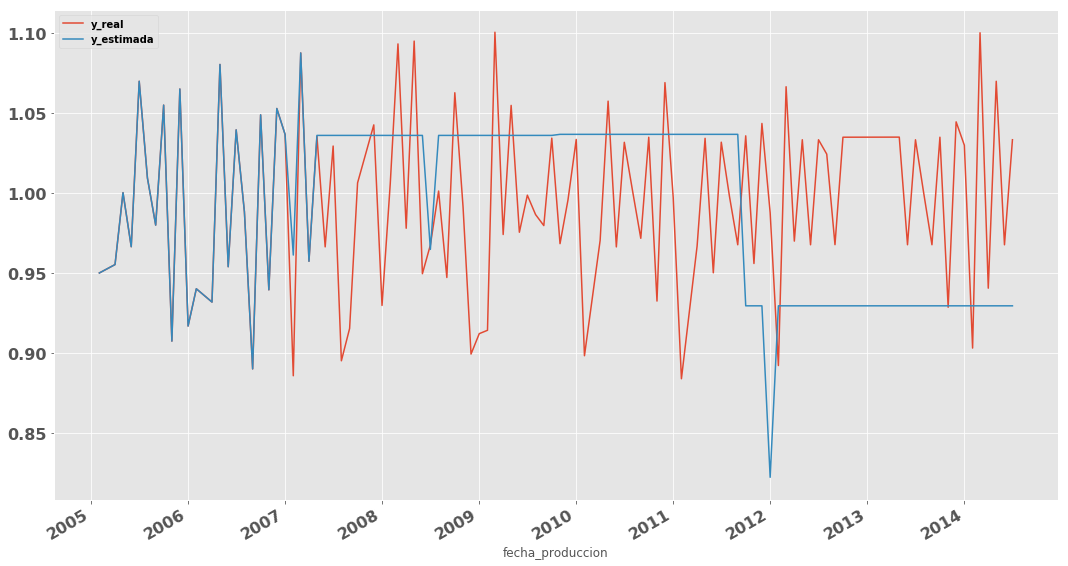

In [241]:
c[['y_real','y_estimada']].plot(figsize=(18,10))

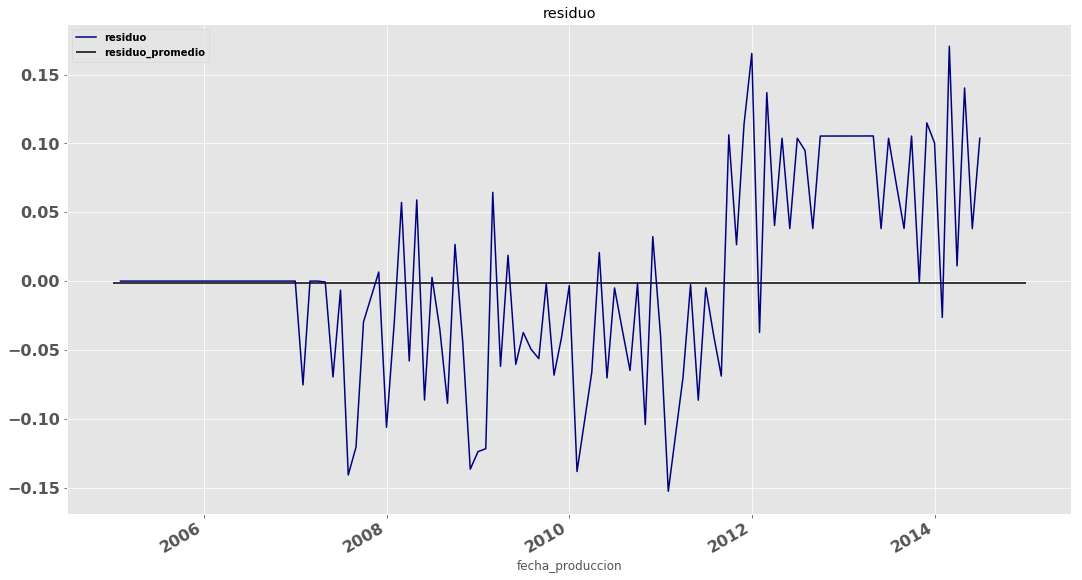

In [242]:
c.residuo.plot(figsize=(18,10),title='residuo', color='navy')
# mi,ma = plt.ylim()
plt.hlines(c.residuo.mean(),'2005-01-01','2015-01-01')
plt.legend(['residuo','residuo_promedio'])
# plt.text('2010-01-01',c.residuo.abs().mean()+5,'residuo promedio % 1.3f' %c.residuo.abs().mean(),fontsize=14)

# Modelo de Gas

Con las mismas variables y metodologia del anterior modelo, entrenamos el modelo de gas. Obteniendo como resultado:

+ $R^2$: 0.8833
+ $R^2$ ajustada$: 0.8588
+ MEA: 0.0066
+ MSE 0.0003
+ RMSE 0.0171

Obteniendo de importancia de variables similar al modelo de Petroleo; de igual manera la prediccion en forecasting es adecuada durante los primeros 5 años de estimacion, posterior a ello crece el error en un 50%

# Entrenamiento

In [161]:
num_cols = [i for i in df_train.columns if i not in ['Pozo',
            'fecha_produccion','Produccion_barriles_t','Produccion_gasMMpc_t',
            'dummi_pico_bajo','prediction','prediction_oil','prediction_gas']]
num_cols

['Produccion_barriles_t_12',
 'Produccion_barriles_t_11',
 'Produccion_barriles_t_10',
 'Produccion_barriles_t_9',
 'Produccion_barriles_t_8',
 'Produccion_barriles_t_7',
 'Produccion_barriles_t_6',
 'Produccion_barriles_t_5',
 'Produccion_barriles_t_4',
 'Produccion_barriles_t_3',
 'Produccion_barriles_t_2',
 'Produccion_barriles_t_1',
 'diff_t_12_t_11',
 'diff_t_11_t_10',
 'diff_t_10_t_9',
 'diff_t_9_t_8',
 'diff_t_8_t_7',
 'diff_t_7_t_6',
 'diff_t_6_t_5',
 'diff_t_5_t_4',
 'diff_t_4_t_3',
 'diff_t_3_t_2',
 'diff_t_6_t_1',
 'diff_t_5_t_1',
 'diff_t_4_t_1',
 'diff_t_3_t_1',
 'diff_t_2_t_1',
 'aceleracion_de_produccion _t3t2_t2t1',
 'aceleracion_de_produccion _t4t3_t2t1',
 'ratio_t_12_t_11',
 'ratio_t_11_t_10',
 'ratio_t_10_t_9',
 'ratio_t_9_t_8',
 'ratio_t_8_t_7',
 'ratio_t_7_t_6',
 'ratio_t_6_t_5',
 'ratio_t_5_t_4',
 'ratio_t_4_t_3',
 'ratio_t_3_t_2',
 'ratio_t_6_t_1',
 'ratio_t_5_t_1',
 'ratio_t_4_t_1',
 'ratio_t_3_t_1',
 'ratio_t_2_t_1',
 'subio_t_12_t_11',
 'subio_t_11_t_10',
 'subio_t_10_t_9',
 'subio_t_9_t_8',
 'subio_t_8_t_7',
 'subio_t_7_t_6',
 'subio_t_6_t_5',
 'subio_t_5_t_4',
 'subio_t_4_t_3',
 'subio_t_3_t_2',
 'subio_t_2_t_1',
 'num_subidas',
 'bajo_t_12_t_11',
 'bajo_t_11_t_10',
 'bajo_t_10_t_9',
 'bajo_t_9_t_8',
 'bajo_t_8_t_7',
 'bajo_t_7_t_6',
 'bajo_t_6_t_5',
 'bajo_t_5_t_4',
 'bajo_t_4_t_3',
 'bajo_t_3_t_2',
 'bajo_t_2_t_1',
 'num_bajadas',
 'std_t_12_t_1',
 'median_t_12_t_1',
 'min_t_12_t_1',
 'q75_t_12_t_1',
 'q25_t_12_t_1',
 'q90_t_12_t_1',
 'q10_t_12_t_1',
 'max_t_12_t_1',
 'rango_t12_t1',
 'media_movil_t_2_t_1',
 'media_movil_t_3_t_1',
 'media_movil_t_4_t_1',
 'media_movil_t_5_t_1',
 'media_movil_t_6_t_1',
 'media_movil_t_12_t_1',
 'Produccion_gasMMpc_t_12',
 'Produccion_gasMMpc_t_11',
 'Produccion_gasMMpc_t_10',
 'Produccion_gasMMpc_t_9',
 'Produccion_gasMMpc_t_8',
 'Produccion_gasMMpc_t_7',
 'Produccion_gasMMpc_t_6',
 'Produccion_gasMMpc_t_5',
 'Produccion_gasMMpc_t_4',
 'Produccion_gasMMpc_t_3',
 'Produccion_gasMMpc_t_2',
 'Produccion_gasMMpc_t_1',
 'stdgas_t_12_t_1',
 'mediangas_t_12_t_1',
 'mingas_t_12_t_1',
 'q75gas_t_12_t_1',
 'q25gas_t_12_t_1',
 'q90gas_t_12_t_1',
 'q10gas_t_12_t_1',
 'maxgas_t_12_t_1',
 'rangogas_t12_t1',
 'media_movilgas_t_2_t_1',
 'media_movilgas_t_3_t_1',
 'media_movilgas_t_4_t_1',
 'media_movilgas_t_5_t_1',
 'media_movilgas_t_6_t_1',
 'media_movilgas_t_12_t_1',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'latitud',
 'longitud',
 'num_pozos_a_menos_de_1km',
 'equipo_perforacion_PM-113',
 'equipo_perforacion_PM-472',
 'equipo_perforacion_PM-504',
 'equipo_perforacion_PM-5571',
 'equipo_perforacion_PM-5596',
 'equipo_perforacion_PM-5597',
 'equipo_perforacion_PM-5599',
 'equipo_perforacion_PM-5626',
 'equipo_perforacion_PM-5627',
 'equipo_perforacion_PM-73',
 'equipo_perforacion_PM-78',
 'equipo_perforacion_PM-92',
 'equipo_perforacion_SIN INFORMACION',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster']

In [162]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_gasMMpc_t')

# Conjunto de validacion

In [163]:
y_valid.index.tolist()

[9606,
 832,
 9019,
 3469,
 9679,
 7883,
 9708,
 998,
 10691,
 8758,
 1289,
 3182,
 4207,
 1996,
 623,
 1719,
 193,
 9557,
 2220,
 7843,
 10322,
 4218,
 4881,
 8573,
 9234,
 6103,
 3813,
 7973,
 9257,
 2600,
 5815,
 5651,
 7488,
 7769,
 8669,
 4497,
 8689,
 4011,
 4068,
 5549,
 4955,
 8009,
 10955,
 7764,
 116,
 7530,
 6258,
 5316,
 801,
 740,
 7786,
 3631,
 2582,
 9409,
 2712,
 6231,
 9696,
 2034,
 6953,
 10891,
 6887,
 5423,
 10778,
 3773,
 5011,
 1665,
 10430,
 3700,
 6808,
 8989,
 1111,
 3504,
 5266,
 1799,
 9622,
 1384,
 7991,
 4133,
 4185,
 5943,
 2957,
 2614,
 9356,
 9101,
 7961,
 10747,
 9643,
 7293,
 10207,
 3393,
 9958,
 7102,
 2343,
 10931,
 3905,
 1274,
 7462,
 6465,
 2809,
 5756,
 14,
 10366,
 8393,
 1374,
 1226,
 7075,
 6904,
 877,
 3345,
 2335,
 2762,
 1889,
 9978,
 925,
 867,
 388,
 10895,
 8553,
 8256,
 7988,
 246,
 5154,
 895,
 9353,
 9637,
 3464,
 10759,
 7001,
 10788,
 6094,
 1792,
 3567,
 1810,
 7192,
 8103,
 9185,
 10372,
 1139,
 10477,
 8624,
 3144,
 5954,
 2937,
 10924,
 3425,
 3016,
 10211,
 5003,
 5277,
 9785,
 1958,
 2140,
 1982,
 4962,
 7890,
 5457,
 9168,
 9402,
 544,
 2005,
 5214,
 531,
 8911,
 932,
 6164,
 6007,
 547,
 3862,
 3284,
 3937,
 1749,
 3992,
 1174,
 5523,
 3678,
 163,
 9927,
 6899,
 2068,
 9245,
 9991,
 10684,
 9515,
 5786,
 10018,
 2882,
 3549,
 3143,
 6338,
 9405,
 5546,
 91,
 734,
 2083,
 6067,
 1470,
 3480,
 5770,
 10830,
 6285,
 37,
 10155,
 10762,
 9984,
 6996,
 7698,
 10249,
 538,
 345,
 8389,
 2006,
 2159,
 2896,
 6960,
 6331,
 3124,
 8136,
 10108,
 2872,
 5317,
 7109,
 9769,
 4117,
 9998,
 2208,
 8988,
 2203,
 3397,
 10454,
 8084,
 2390,
 6588,
 3742,
 3212,
 319,
 2636,
 5468,
 6921,
 4159,
 6364,
 8175,
 7836,
 3498,
 2503,
 1434,
 7271,
 7697,
 5061,
 87,
 2685,
 3637,
 8425,
 619,
 8576,
 9451,
 8490,
 2589,
 8649,
 1031,
 10027,
 2042,
 5595,
 8237,
 4582,
 1159,
 9818,
 7685,
 8195,
 6306,
 5553,
 2317,
 4890,
 3680,
 9048,
 1165,
 5062,
 2293,
 6278,
 5721,
 4163,
 9304,
 95,
 5074,
 10110,
 4345,
 7134,
 7956,
 160,
 5359,
 7785,
 7025,
 2901,
 9290,
 2219,
 99,
 10319,
 10368,
 835,
 4900,
 5064,
 6795,
 4249,
 10280,
 1865,
 4996,
 4607,
 8320,
 6043,
 6216,
 4350,
 6610,
 1716,
 4805,
 10051,
 6665,
 5029,
 3281,
 4554,
 8143,
 3562,
 3261,
 4549,
 5040,
 7573,
 9384,
 4903,
 6324,
 1169,
 5171,
 3632,
 7761,
 10571,
 2911,
 6818,
 10914,
 10221,
 10456,
 9746,
 4995,
 9948,
 6609,
 2788,
 9504,
 8778,
 10267,
 3651,
 5230,
 9526,
 4907,
 3407,
 5329,
 5100,
 5615,
 5297,
 3803,
 6496,
 4055,
 9366,
 4958,
 1269,
 8417,
 7645,
 5519,
 6362,
 3739,
 8102,
 9147,
 5293,
 1296,
 7989,
 6561,
 5632,
 55,
 9633,
 2512,
 4799,
 1572,
 1530,
 629,
 10429,
 7644,
 9636,
 2747,
 3448,
 1196,
 3308,
 4132,
 5859,
 7590,
 9142,
 3170,
 3121,
 6441,
 1097,
 2552,
 5825,
 5823,
 5655,
 5289,
 7356,
 8540,
 6019,
 4863,
 10406,
 154,
 9646,
 7526,
 5384,
 4436,
 8145,
 7142,
 1674,
 62,
 10030,
 5098,
 2750,
 4199,
 4227,
 9032,
 5465,
 7875,
 5968,
 1413,
 10139,
 7832,
 5556,
 5429,
 6063,
 10897,
 6225,
 752,
 3028,
 7440,
 2629,
 5646,
 5299,
 8739,
 8236,
 1155,
 3468,
 10756,
 10095,
 6667,
 1002,
 837,
 4904,
 7808,
 8123,
 1061,
 882,
 5089,
 3933,
 1963,
 953,
 7559,
 6578,
 10389,
 4992,
 2123,
 10545,
 7358,
 2107,
 6234,
 5960,
 2707,
 10411,
 1259,
 10448,
 5392,
 2858,
 285,
 3186,
 8182,
 506,
 442,
 2097,
 2922,
 529,
 6971,
 4977,
 1125,
 4801,
 3952,
 7791,
 2639,
 2942,
 7442,
 10421,
 3300,
 4892,
 2085,
 9493,
 8785,
 7797,
 4155,
 2817,
 2112,
 5828,
 346,
 3415,
 149,
 3088,
 8640,
 3781,
 5362,
 1432,
 748,
 3607,
 2772,
 831,
 10172,
 7375,
 8205,
 3677,
 6348,
 1819,
 7548,
 6405,
 7094,
 1404,
 2277,
 7119,
 54,
 5436,
 2453,
 9391,
 1473,
 5945,
 3763,
 23,
 9487,
 10855,
 10283,
 2260,
 10374,
 174,
 7706,
 795,
 4797,
 6839,
 9362,
 1359,
 10583,
 3010,
 8598,
 1166,
 1468,
 2153,
 6188,
 7655,
 4366,
 2703,
 8763,
 3717,
 5239,
 6697,
 6168,
 443,
 10605,
 9066,
 212,
 9510,
 7716,
 3833,
 5421,
 3346,
 8071,
 3470,
 2398,
 1283,
 9486,
 9763,
 2793

# seguimos entrenando

In [164]:
x_train.shape

(7892, 144)

In [165]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
[10000]	valid_0's l1: 0.0107609
Early stopping, best iteration is:
[12820]	valid_0's l1: 0.0107478


In [166]:
clf.num_trees()

12820

# Evaluacion

In [167]:
y_pred = clf.predict(x_valid)

In [168]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [169]:
y_valid.mean()

0.15417502278942577

In [170]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.7324
R^2 ajustada$: 0.6920
MEA: 0.0115
MSE 0.0020
RMSE 0.0453


In [171]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

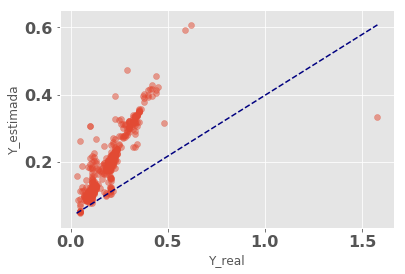

In [172]:
yy_plot(y_valid, y_pred)

## Residuos

In [173]:
res = (y_valid - y_pred) / y_valid

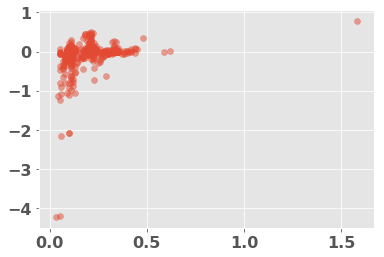

In [174]:
plt.scatter(y_valid, res, alpha=0.5)

In [175]:
res.median() * 100

0.015693427924401426

In [176]:
res.mean() * 100

-3.5071195563585276

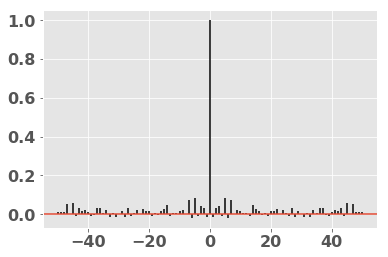

In [177]:
plt.xcorr(res, res,maxlags=50, usevlines=1)
plt.show()

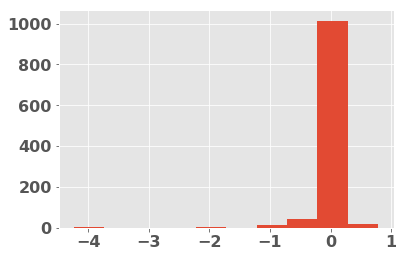

In [178]:
res.hist()

## Autocorrelacion

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

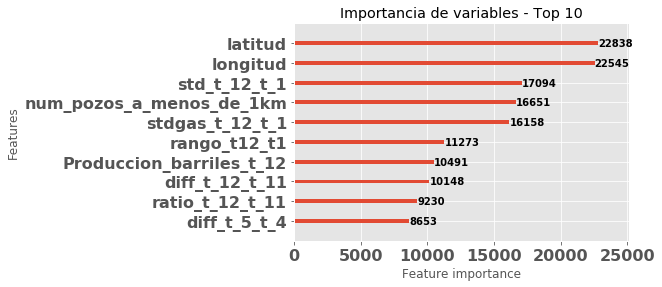

In [179]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [180]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [181]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [182]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [183]:
a.tail(8).index

Index(['diff_t_12_t_11', 'Produccion_barriles_t_12', 'rango_t12_t1',
       'stdgas_t_12_t_1', 'num_pozos_a_menos_de_1km', 'std_t_12_t_1',
       'longitud', 'latitud'],
      dtype='object')

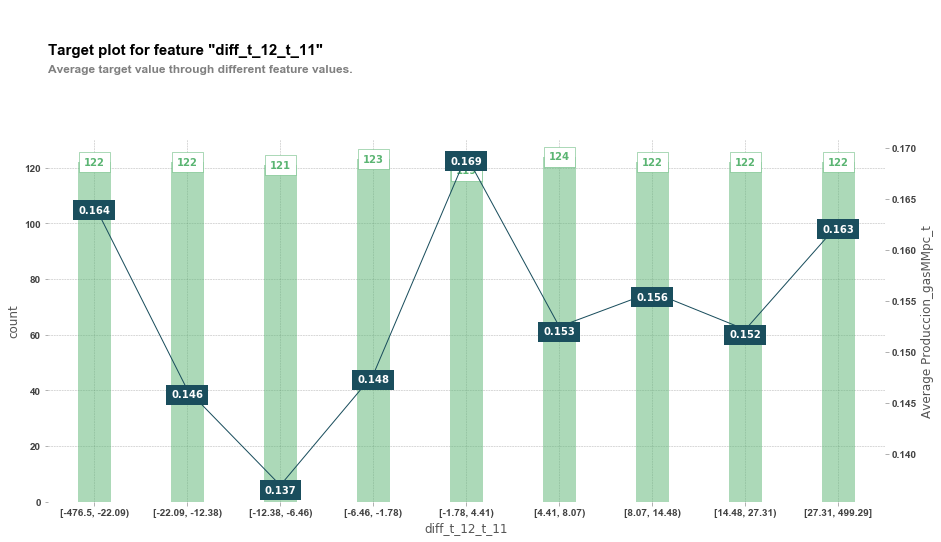

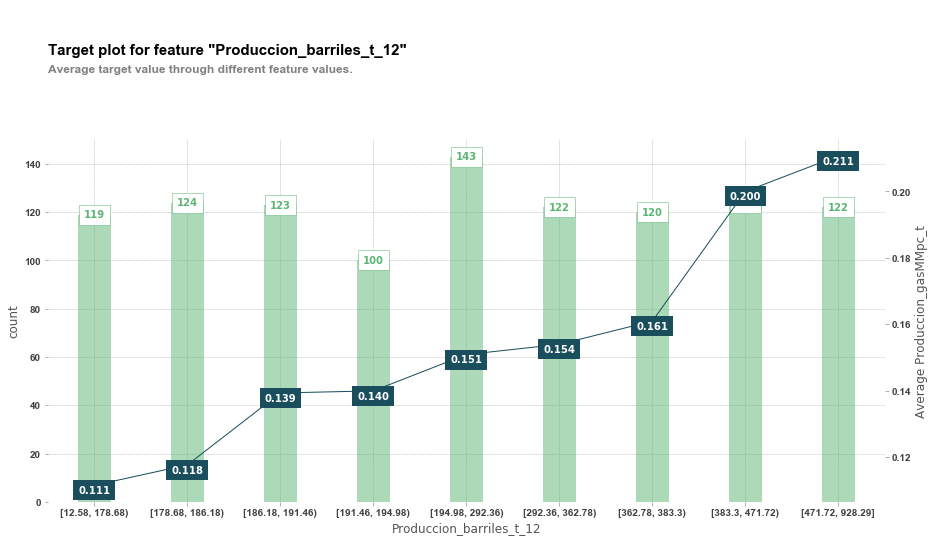

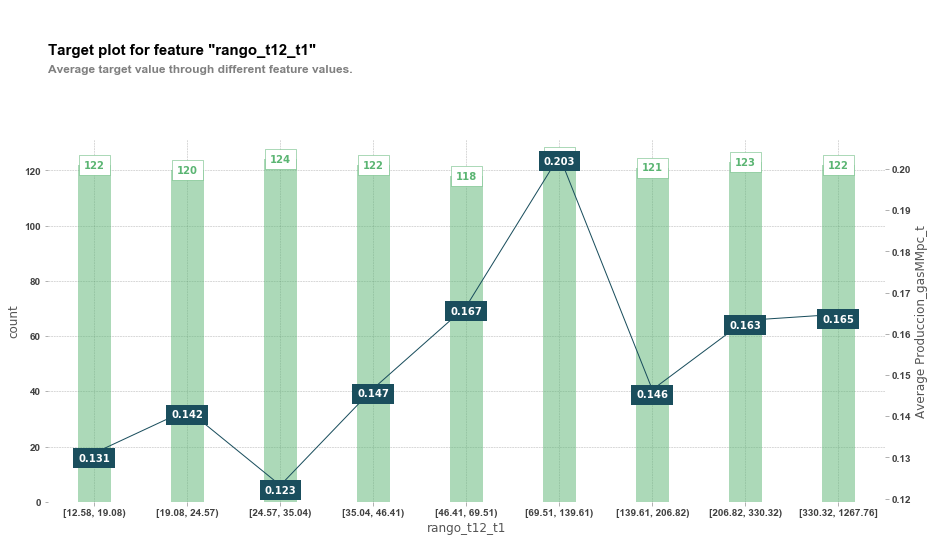

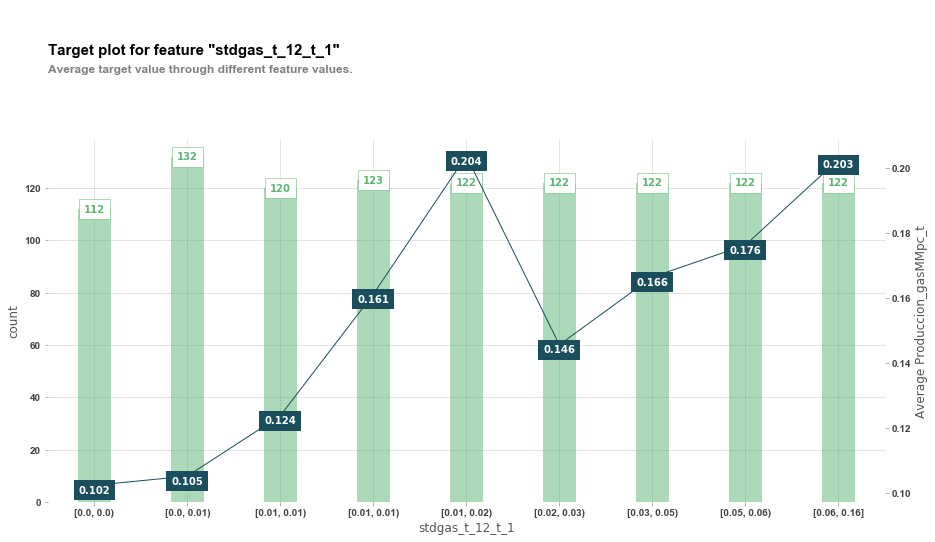

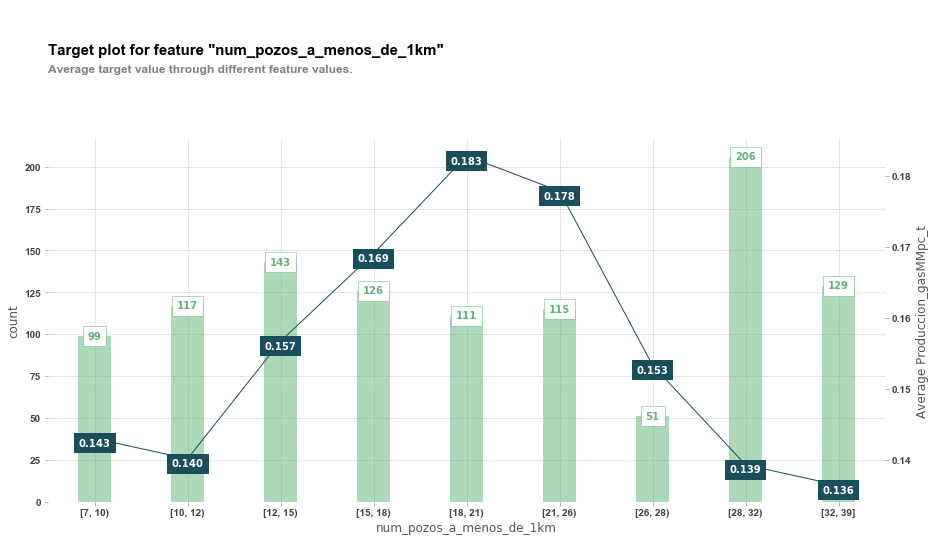

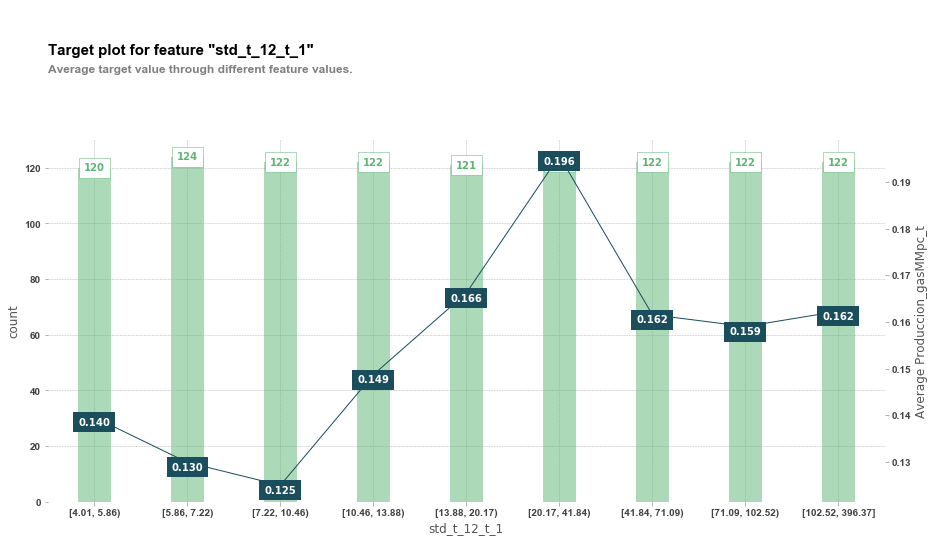

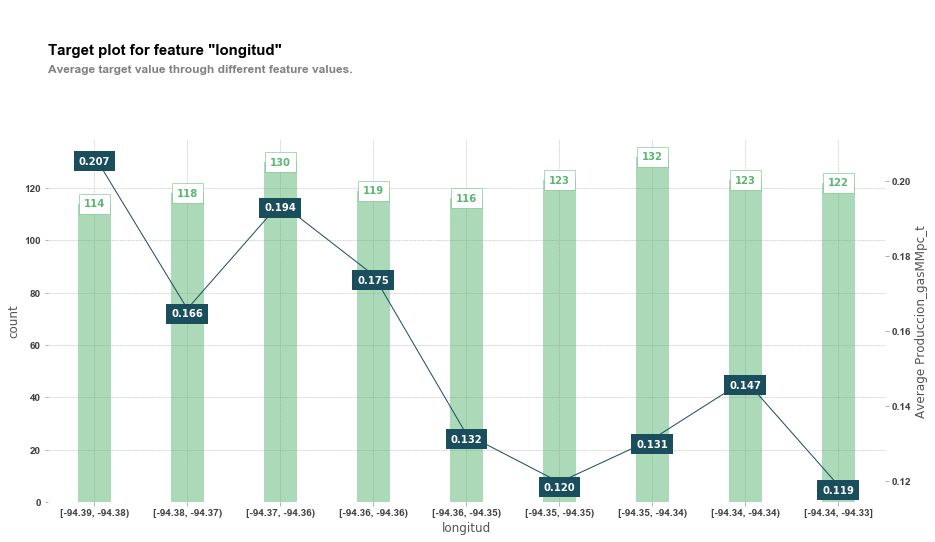

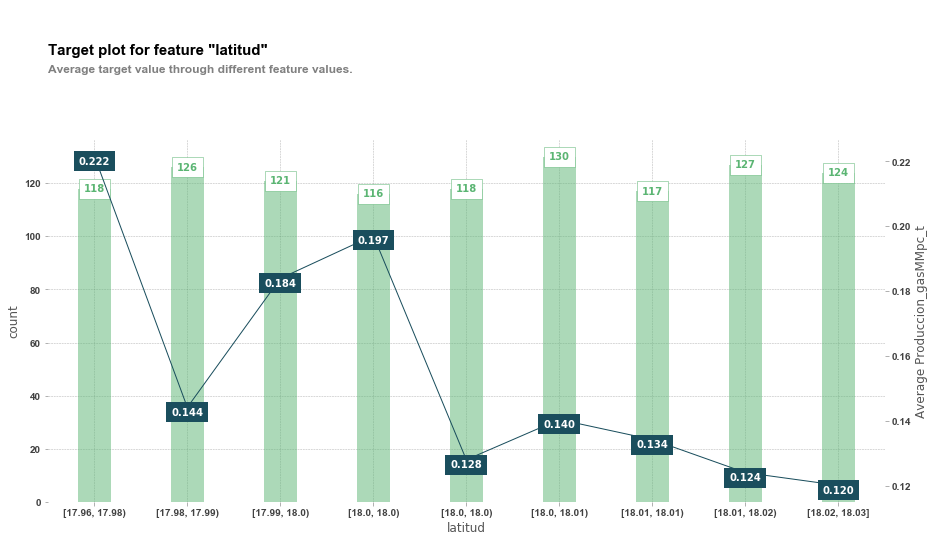

In [184]:
for col in a.tail(8).index:
    fig, axes, summary_df = info_plots.target_plot(
        df=pd.concat([x_valid,y_valid],1)
        , feature=col, 
        feature_name=col, 
        target='Produccion_gasMMpc_t'
    )

## Pendiente interpretar los de shap

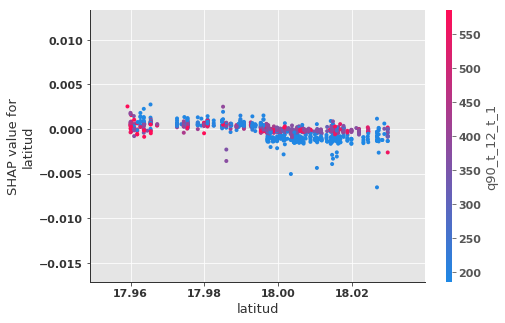

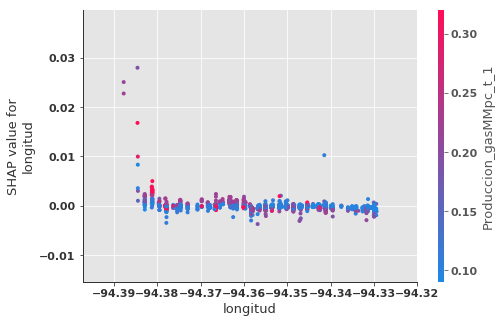

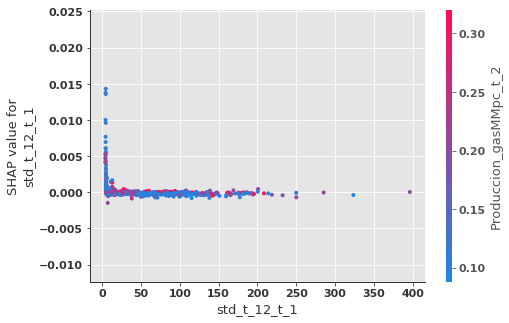

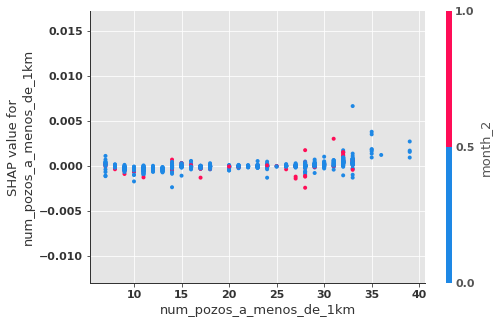

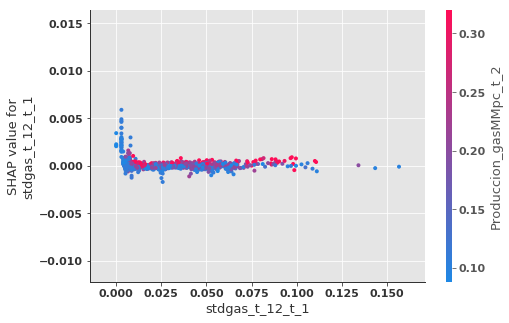

In [185]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Guardado de mejor modelo

In [186]:
joblib.dump(clf, 'light_gbm_gas_01-08-2019.pkl')
# load model
# gbm_pickle = joblib.load('light_gbm_31-07-2019.pkl')

['light_gbm_gas_01-08-2019.pkl']

In [187]:
# carga de modelo
# gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Pozo promedio

In [195]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_gasMMpc_t

In [196]:
df_train['prediction_gas'] = preds

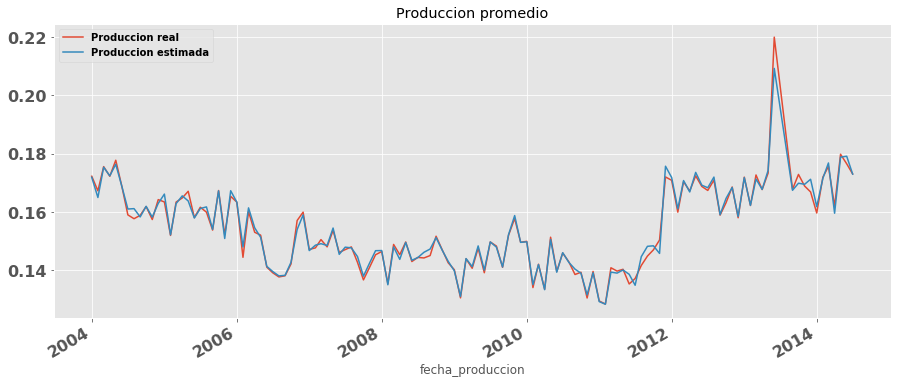

In [197]:
df_train.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [198]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

84.5

In [199]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[
    df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [200]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [201]:
df_vivos = df_vivos[df_vivos.fecha_produccion > '2003-12-01']

In [202]:
a = df_vivos.groupby('Pozo').fecha_produccion.min()
idx_a = a[a=='2004-01-01'].index

In [203]:
df_vivos = df_vivos[df_vivos.Pozo.isin(idx_a)]

In [204]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [205]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_gasMMpc_t','prediction_gas']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_gasMMpc_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction_gas'].quantile(0.10)
df_vivos2['residuo'] = df_vivos2.Produccion_gasMMpc_t - df_vivos2.prediction_gas

In [206]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

In [207]:
df_vivos2.to_csv("perfiles_pozo_gas.csv")